# **CS624-Assignment-2**

<h1><strong><font color='Green'>Classification Analysis of Potentially Hazardous Nearest Earth Object(NEO) using Machine Learning Techniques and Deep Learning Techniques</font> </em></strong> </h1>

**<h1><strong><font color='#0685c4'>Abstract</font> </em></strong> </h1>**

A Solar System body is a NEO if its closest approach to the Sun is less than 1.3 astronomical units (AU). If a NEO's orbit crosses the Earth's orbit, and the object is larger than 140 meters (460 ft) across, it is considered a potentially hazardous.

There is an infinite number of objects in the outer space. Some of them are closer than we think. Even though we might think that a distance of 70,000 Km cannot potentially harm us, but at an astronomical scale, this is a very small distance and can disrupt many natural phenomena. These objects/asteroids can thus prove to be harmful. Hence, it is wise to know what is surrounding us and what can harm us amongst those. Thus, this dataset compiles the list of NASA certified asteroids that are classified as the nearest earth object.

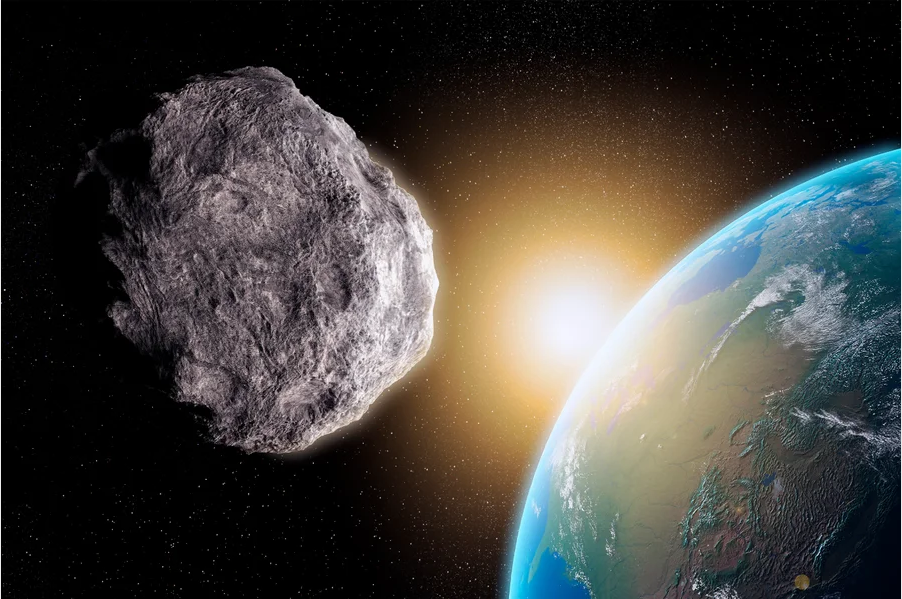

**<h1><strong><font color='#0685c4'>Dataset Details</font> </em></strong> </h1>**

### **Objective**
  * Solve classification problem whether the object is near to earth or not for any harzardous situations.


### **Fields**
* id:Unique Identifier for each Asteroid
* name: Name given by NASA
* est_diameter_min: Minimum Estimated Diameter in Kilometres
* est_diameter_max: Maximum Estimated Diameter in Kilometres
* relative_velocity: Velocity Relative to Earth
* miss_distance: Distance in Kilometres missed
* orbiting_body: Planet that the asteroid orbits
* sentry_object: Included in sentry - an automated collision monitoring system
* absolute_magnitude:Describes intrinsic luminosity
* hazardous:Boolean feature that shows whether asteroid is harmful or not



### **Data Sources**

Daily updating data on objects within 0.2 au of Earth

NASA Open API => <https://api.nasa.gov/>

NEO Earth Close Approaches => <https://cneos.jpl.nasa.gov/ca/>



### **How the Dataset is generated**
CNEOS software detects predicted Earth close approaches for all known NEOs, in both the past and the future, and tabulates the close approach data organized by time

<h1><strong><font color='#0685c4'>Import Python Libraries</font> </em></strong> </h1>

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm

#Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

#OverSampling
from imblearn.over_sampling import RandomOverSampler

#Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import tree
#ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report

#Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

#Deep Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F


import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


<h1><strong><font color='#0685c4'>Data Acquisition</font> </em></strong> </h1>

In [ ]:
%%capture
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d sameepvani/nasa-nearest-earth-objects
! unzip nasa-nearest-earth-objects.zip

In [ ]:
# Class for data acquisition
class DataAcquisition:

  def __init__(self,datasetname):
    self.datasetname = datasetname

  def ReadCsv(self):
    raw_data = pd.read_csv(os.path.join('/content/',self.datasetname),
                           sep=',',encoding='UTF-8')
    return raw_data
acq = DataAcquisition('neo_v2.csv')
raw_data = acq.ReadCsv()
raw_data.head()

id                 name  est_diameter_min  est_diameter_max  \
0  2162635  162635 (2000 SS164)          1.198271          2.679415   
1  2277475    277475 (2005 WK4)          0.265800          0.594347   
2  2512244   512244 (2015 YE18)          0.722030          1.614507   
3  3596030          (2012 BV13)          0.096506          0.215794   
4  3667127          (2014 GE35)          0.255009          0.570217   

   relative_velocity  miss_distance orbiting_body  sentry_object  \
0       13569.249224   5.483974e+07         Earth          False   
1       73588.726663   6.143813e+07         Earth          False   
2      114258.692129   4.979872e+07         Earth          False   
3       24764.303138   2.543497e+07         Earth          False   
4       42737.733765   4.627557e+07         Earth          False   

   absolute_magnitude  hazardous  
0               16.73      False  
1               20.00       True  
2               17.83      False  
3               22.20      False  
4               20.09       True

<h1><strong><font color='#0685c4'>Data Summary</font> </em></strong> </h1>

In [ ]:
# Class for data preprocessing
class DataPreprocessing:

  def __init__(self,dataframe):
    self.dataframe = dataframe

  def DatasetInfo(self):
    self.dataframe.info()

  def ShowBasicInfo(self):
    # Display basic information about the dataset
    print(f'Number of samples:{raw_data.shape[0]}')
    print(f'Number of features:{raw_data.shape[1]}')
    print(f'Feature names:{raw_data.columns}')
    print(f'Target classes:{raw_data["hazardous"].unique()}')

  def Summary(self):
        summ = pd.DataFrame(self.dataframe.dtypes, columns=['dtypes'])
        summ['null'] = self.dataframe.isnull().sum()
        summ['unique'] = self.dataframe.nunique()
        summ['min'] = self.dataframe.min()
        summ['median'] = self.dataframe.median()
        summ['max'] = self.dataframe.max()
        summ['mean'] =  self.dataframe.mean()
        summ['std'] =  self.dataframe.std()
        summ['duplicate'] =  self.dataframe.duplicated().sum()
        return summ


preproc = DataPreprocessing(raw_data)

In [ ]:
#Dataset information
preproc.DatasetInfo()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [ ]:
preproc.ShowBasicInfo()

Number of samples:90836
Number of features:10
Feature names:Index(['id', 'name', 'est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance', 'orbiting_body', 'sentry_object',
       'absolute_magnitude', 'hazardous'],
      dtype='object')
Target classes:[False  True]


### **Observations**

* There are total 90836  rows in the dataset and 10 fields.
* There 5 float 1 integer 2 object and 2 bool type data.
* All the object datatype should be changed to approprirate datatypes.

In [ ]:
# Dataset Summary
summary=preproc.Summary().T
summary

id                      name est_diameter_min  \
dtypes               int64                    object          float64   
null                     0                         0                0   
unique               27423                     27423             1638   
min                2000433                 (1983 LC)         0.000609   
median           3748362.0                       NaN         0.048368   
max               54275914  99942 Apophis (2004 MN4)         37.89265   
mean        14382878.05216                       NaN         0.127432   
std        20872018.353893                       NaN         0.298511   
duplicate                0                         0                0   

          est_diameter_max relative_velocity    miss_distance orbiting_body  \
dtypes             float64           float64          float64        object   
null                     0                 0                0             0   
unique                1638             90828            90536             1   
min               0.001362        203.346433      6745.532516         Earth   
median            0.108153       44190.11789  37846579.263426           NaN   
max              84.730541     236990.128088  74798651.452197         Earth   
mean              0.284947      48066.918918  37066546.030422           NaN   
std               0.667491      25293.296961   22352040.59919           NaN   
duplicate                0                 0                0             0   

          sentry_object absolute_magnitude hazardous  
dtypes             bool            float64      bool  
null                  0                  0         0  
unique                1               1638         2  
min               False               9.23     False  
median              0.0               23.7       0.0  
max               False               33.2      True  
mean                0.0          23.527103  0.097318  
std                 0.0           2.894086  0.296392  
duplicate             0                  0         0

<h1><strong><font color='#0685c4'>Exploratory Data Analysis</font> </em></strong> </h1>

In [ ]:
#Dropping two columns 'orbiting_body' & 'sentry_object'
#raw_data = raw_data.drop(['id','name',"orbiting_body","sentry_object"], axis=1)
raw_data = raw_data.drop(['id','name'], axis=1)
raw_data

est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
0              1.198271          2.679415       13569.249224   5.483974e+07   
1              0.265800          0.594347       73588.726663   6.143813e+07   
2              0.722030          1.614507      114258.692129   4.979872e+07   
3              0.096506          0.215794       24764.303138   2.543497e+07   
4              0.255009          0.570217       42737.733765   4.627557e+07   
...                 ...               ...                ...            ...   
90831          0.026580          0.059435       52078.886692   1.230039e+07   
90832          0.016771          0.037501       46114.605073   5.432121e+07   
90833          0.031956          0.071456        7566.807732   2.840077e+07   
90834          0.007321          0.016370       69199.154484   6.869206e+07   
90835          0.039862          0.089133       27024.455553   5.977213e+07   

      orbiting_body  sentry_object  absolute_magnitude  hazardous  
0             Earth          False               16.73      False  
1             Earth          False               20.00       True  
2             Earth          False               17.83      False  
3             Earth          False               22.20      False  
4             Earth          False               20.09       True  
...             ...            ...                 ...        ...  
90831         Earth          False               25.00      False  
90832         Earth          False               26.00      False  
90833         Earth          False               24.60      False  
90834         Earth          False               27.80      False  
90835         Earth          False               24.12      False  

[90836 rows x 8 columns]

In [ ]:
#Finding number of hazardous/Non-hazardous objects count
print("Number of hazardous/Non-hazardous objects: \n")
print(raw_data["hazardous"].value_counts())
print("")
print("Percentage of hazardous/Non-hazardous objects: \n")
print((raw_data["hazardous"].value_counts() / len(raw_data))*100)



Number of hazardous/Non-hazardous objects: 

False    81996
True      8840
Name: hazardous, dtype: int64

Percentage of hazardous/Non-hazardous objects: 

False    90.268176
True      9.731824
Name: hazardous, dtype: float64


### **Observations**
So, there are 9.7% of hazardous objects found in the dataset.

In [ ]:
# Separating Numeric Data
continuous_features = ["est_diameter_min","est_diameter_max","relative_velocity","miss_distance","absolute_magnitude"]
label = raw_data['hazardous']

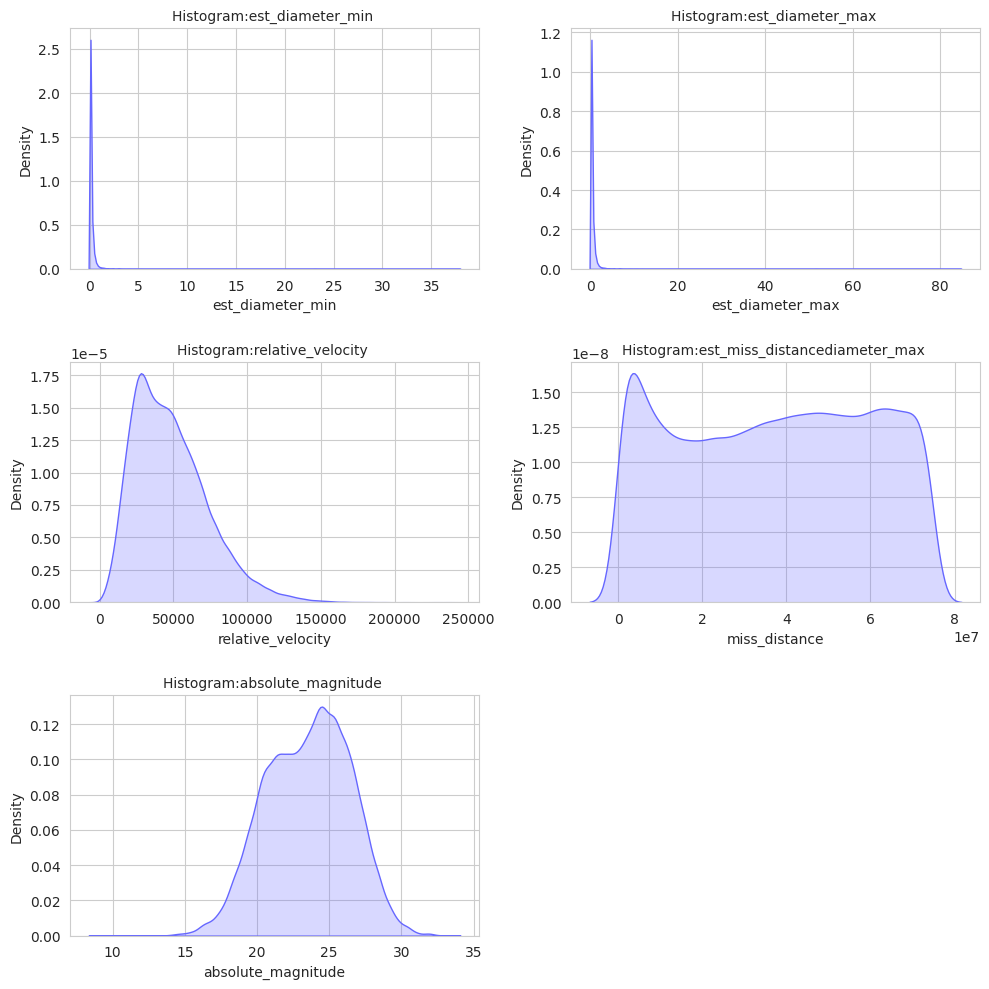

In [ ]:
# Visualization: Histogram
f = plt.figure(figsize=(10,10))
gs = f.add_gridspec(3, 2)
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.kdeplot(data=raw_data, x=raw_data['est_diameter_min'],color='#6667ff',fill=True)
    plt.title(f'Histogram:est_diameter_min ', fontsize=10)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.kdeplot(data=raw_data, x=raw_data['est_diameter_max'],color='#6667ff',fill=True)
    plt.title(f'Histogram:est_diameter_max ', fontsize=10)


with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.kdeplot(data=raw_data, x=raw_data['relative_velocity'],color='#6667ff',fill=True)
    plt.title(f'Histogram:relative_velocity ', fontsize=10)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[1, 1])
    sns.kdeplot(data=raw_data, x=raw_data['miss_distance'],color='#6667ff',fill=True)
    plt.title(f'Histogram:est_miss_distancediameter_max ', fontsize=10)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[2, 0])
    sns.kdeplot(data=raw_data, x=raw_data['absolute_magnitude'],color='#6667ff',fill=True)
    plt.title(f'Histogram:absolute_magnitude ', fontsize=10)

f.tight_layout()


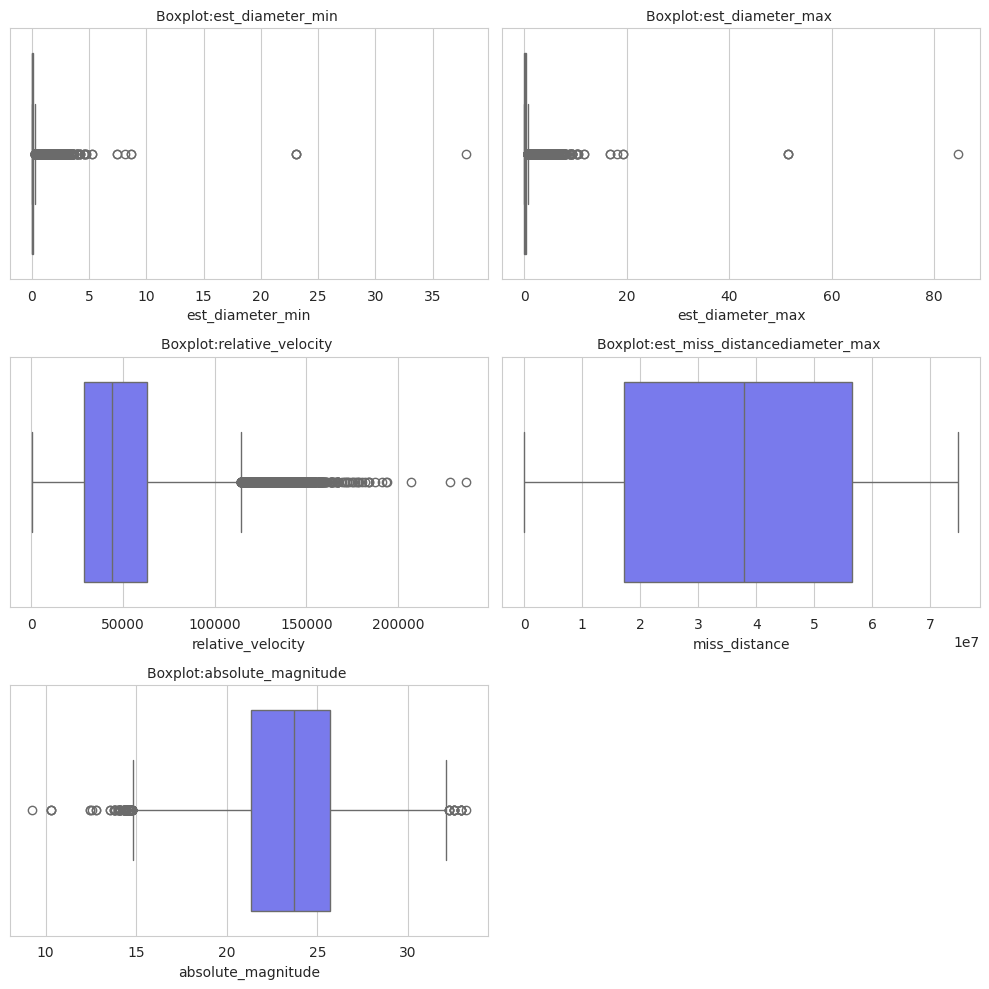

In [ ]:
# Visualization: Boxplot
f = plt.figure(figsize=(10,10))
gs = f.add_gridspec(3, 2)
with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.boxplot(data=raw_data, x=raw_data['est_diameter_min'],color='#6667ff',fill=True)
    plt.title(f'Boxplot:est_diameter_min ', fontsize=10)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.boxplot(data=raw_data, x=raw_data['est_diameter_max'],color='#6667ff',fill=True)
    plt.title(f'Boxplot:est_diameter_max ', fontsize=10)


with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.boxplot(data=raw_data, x=raw_data['relative_velocity'],color='#6667ff',fill=True)
    plt.title(f'Boxplot:relative_velocity ', fontsize=10)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[1, 1])
    sns.boxplot(data=raw_data, x=raw_data['miss_distance'],color='#6667ff',fill=True)
    plt.title(f'Boxplot:est_miss_distancediameter_max ', fontsize=10)

with sns.axes_style("whitegrid"):
    ax = f.add_subplot(gs[2, 0])
    sns.boxplot(data=raw_data, x=raw_data['absolute_magnitude'],color='#6667ff',fill=True)
    plt.title(f'Boxplot:absolute_magnitude ', fontsize=10)

f.tight_layout()

## **Observations**

* Except miss_distance all the features have outliers as clearly seen in box plot.
* Est_diamter_min and est_diameter_max have minimal median values.


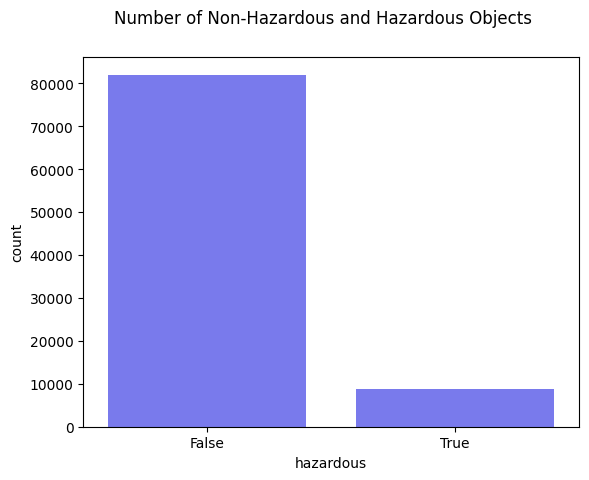

In [ ]:
sns.axes_style("whitegrid")
sns.countplot(x='hazardous',data=raw_data,color='#6667ff',fill=True)
plt.suptitle('Number of Non-Hazardous and Hazardous Objects')
plt.rcParams['figure.figsize']=[4,4]
plt.show()

## Observations

* The dataset is clearly imbalanced.
* There are more False values then True values.

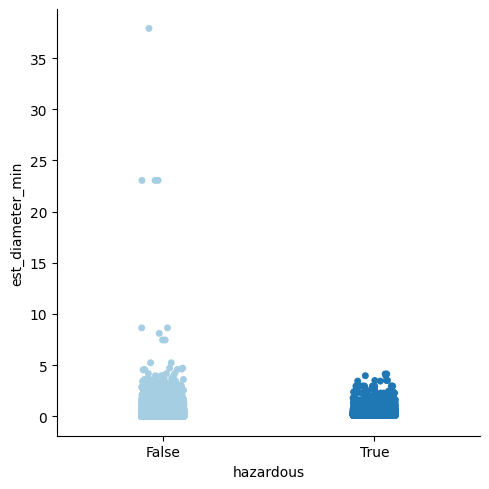

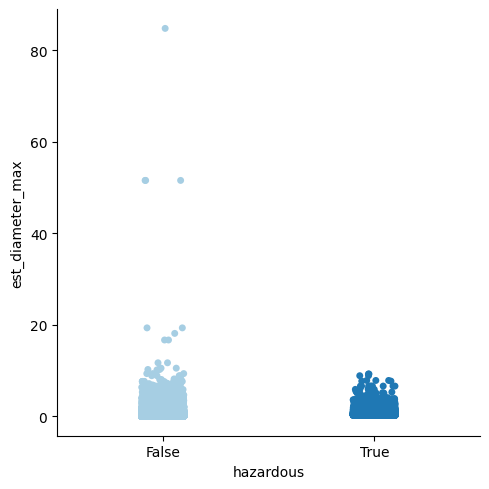

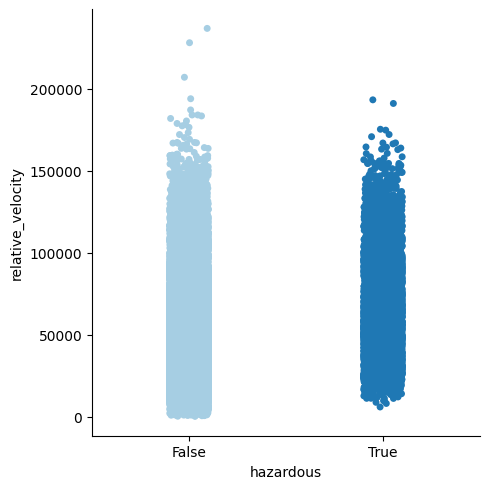

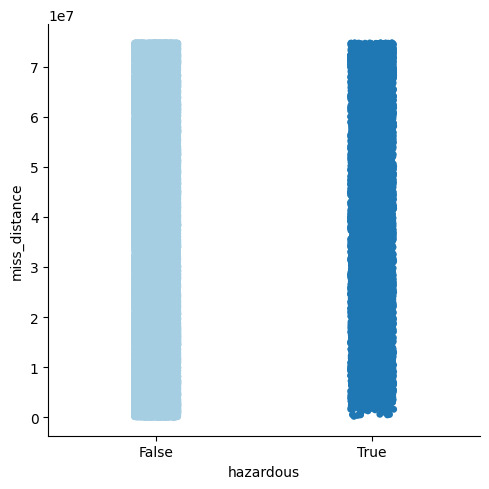

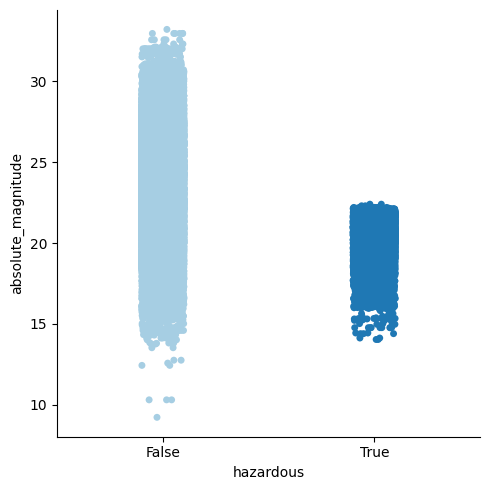

In [ ]:
# Distribution of label wrt to each numerical featuers
sns.catplot(x = "hazardous", y = "est_diameter_min", palette = "Paired", data = raw_data)
sns.catplot(x = "hazardous", y = "est_diameter_max", palette = "Paired", data = raw_data)
sns.catplot(x = "hazardous", y = "relative_velocity", palette = "Paired", data = raw_data)
sns.catplot(x = "hazardous", y = "miss_distance", palette = "Paired", data = raw_data)
sns.catplot(x = "hazardous", y = "absolute_magnitude", palette = "Paired", data = raw_data)



### **Observations**

* The data is highly imbalanced.
* There are outliers in the continous features
* Absolute magnitude is somewhat normal distributed
* Est_diameter_min,Est_diameter_max and relatvie velocity are higly righ skewed.
* The distribution of absolute_magnitude wrt hazardous is un even.

<h1><strong><font color='#0685c4'>Data Cleansing</font> </em></strong> </h1>

In [ ]:
class CleanDataset:

  def __init__(self,dataset):
    self.raw_data = dataset

  def RemoveOutlier(self):
    outliers_removed = 0
    for feature in continuous_features:
      Q1 =  self.raw_data[feature].quantile(0.25)
      Q3 =  self.raw_data[feature].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      # Find outliers
      condition = ( self.raw_data[feature] < lower_bound) | ( self.raw_data[feature] > upper_bound)
      outliers_count = self.raw_data[condition].shape[0]
      outliers_removed += outliers_count
      # Remove outliers
      self.raw_data = self.raw_data[~condition]

    return self.raw_data,outliers_removed


cln = CleanDataset(raw_data)


In [ ]:
# Summary of Data Cleaning
clean_data,outliers_removed  = cln.RemoveOutlier()
print(f"Removed a total of {outliers_removed} outliers across selected features.")
cleaning_summary = f"""
After cleaning, the dataset has {clean_data.shape[0]} rows and {clean_data.shape[1]} columns.
"""
print(cleaning_summary)

Removed a total of 14169 outliers across selected features.

After cleaning, the dataset has 76667 rows and 8 columns.



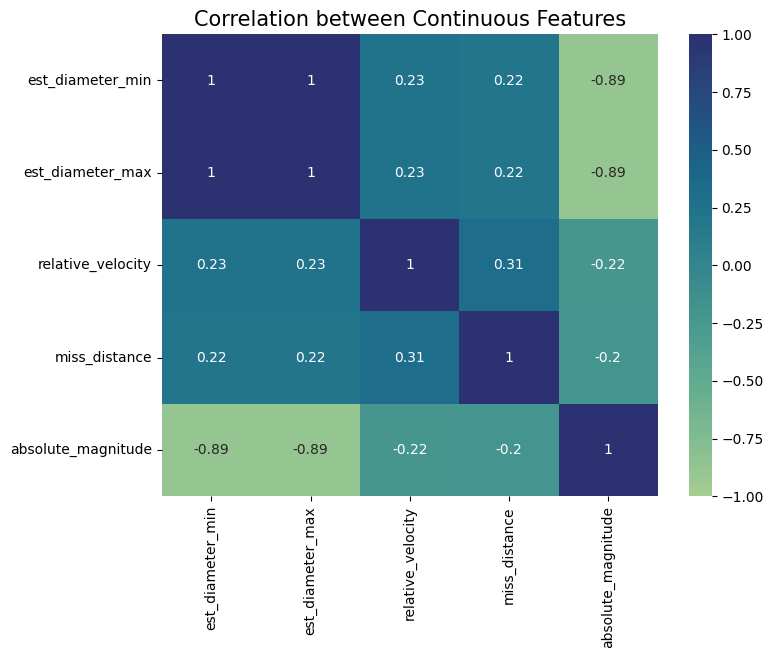

In [ ]:
# correlation matrix
correlation = clean_data[continuous_features].corr()
# visualization - heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True,cmap="crest")
plt.title('Correlation between Continuous Features', fontsize=15)
plt.show()

## Observations

* Est_diamter_min and est_diameter_max are closely related features.
* Relative_velocity and miss_distance are closely related.
* Absolute magnitude,Est_diamter_min and est_diameter_max are highly co related features.


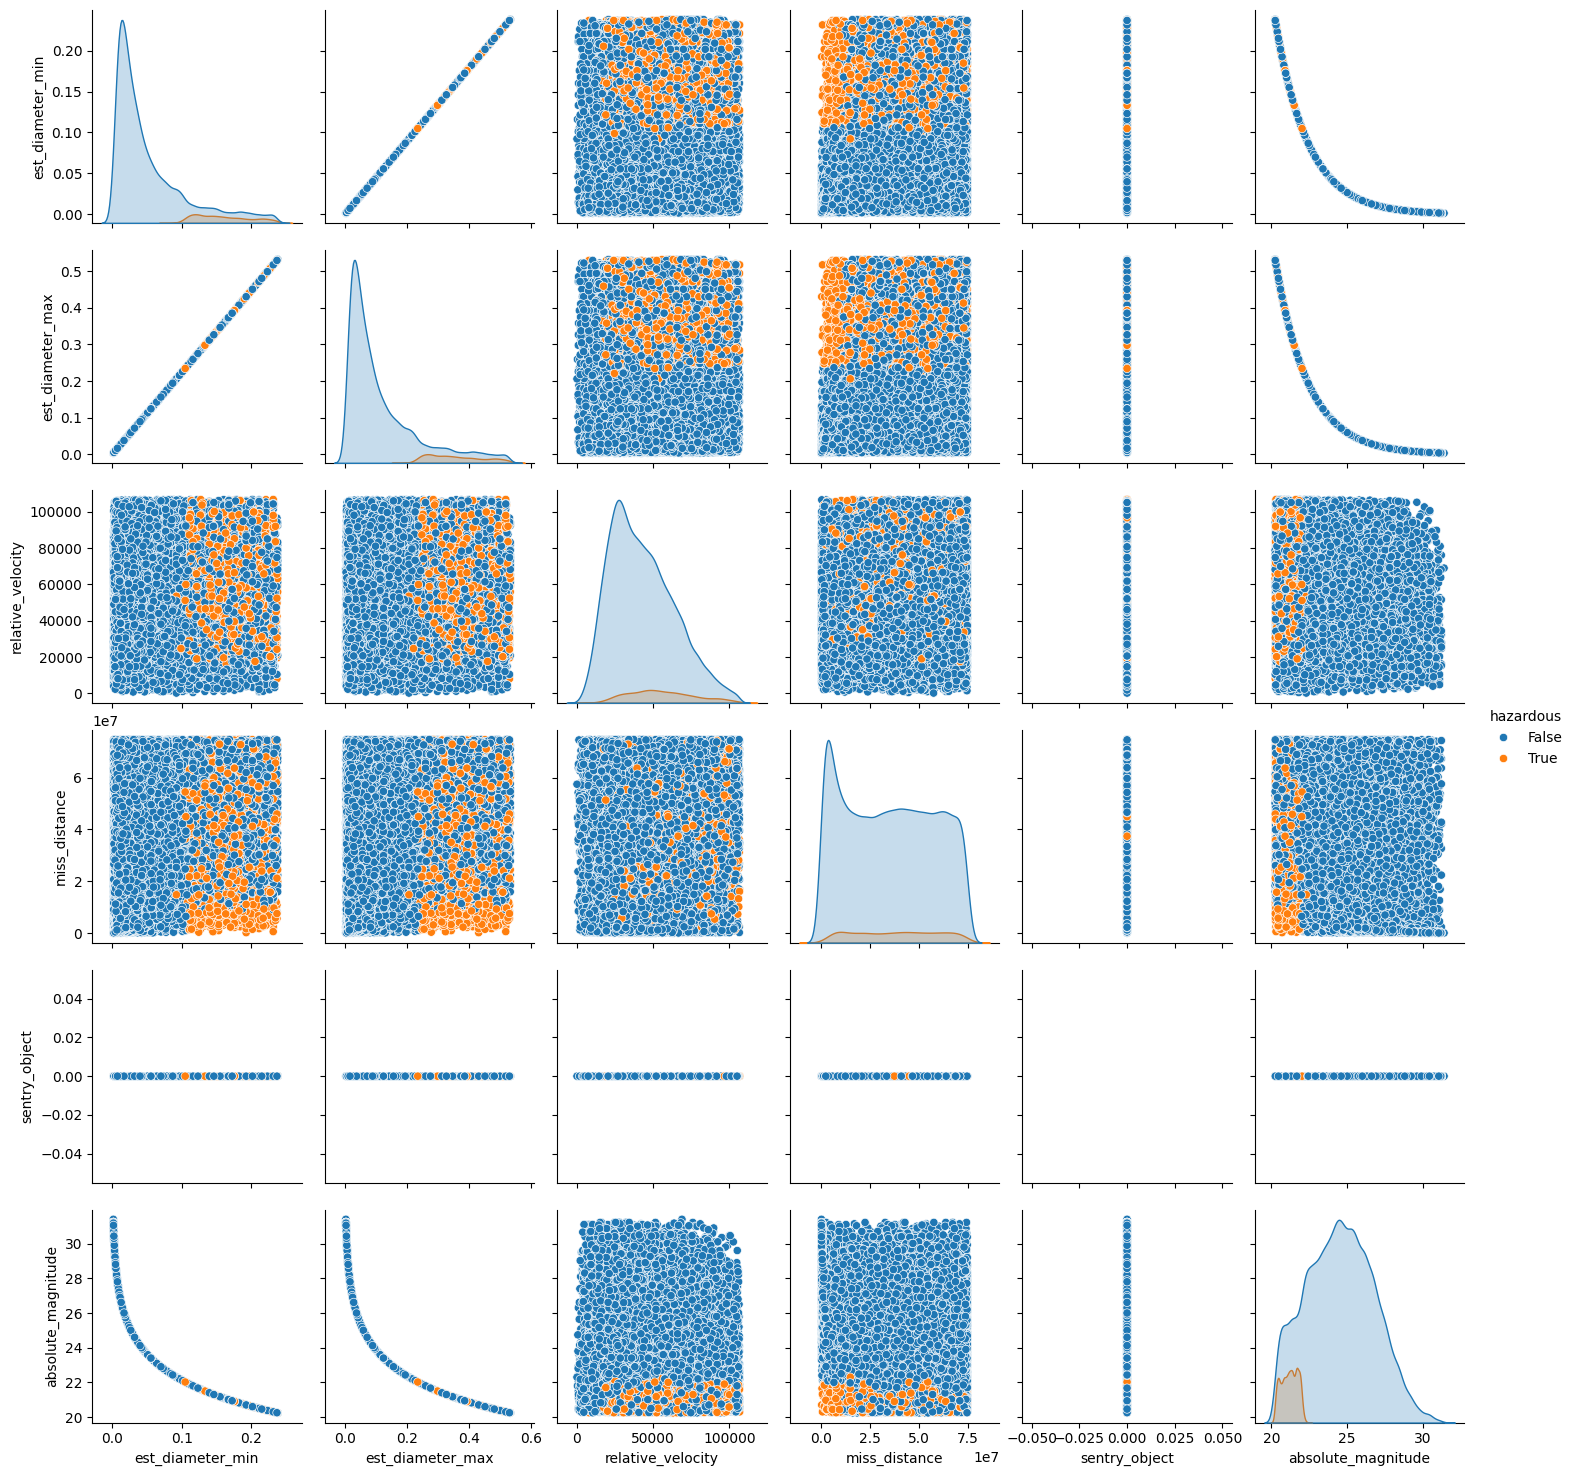

In [ ]:
# Pairplot
sns.pairplot(clean_data, hue = "hazardous")

<h1><strong><font color='#0685c4'>Encoding Label to 1 or 0 for ML</font> </em></strong> </h1>

In [ ]:
print(clean_data['orbiting_body'].value_counts())
print(clean_data['sentry_object'].value_counts())
clean_data = clean_data.drop(['orbiting_body','sentry_object'], axis=1)

Earth    76667
Name: orbiting_body, dtype: int64
False    76667
Name: sentry_object, dtype: int64


In [ ]:
from sklearn.preprocessing import OneHotEncoder

#label_encoder_hazardous = LabelEncoder()
onehot =OneHotEncoder()
clean_data['hazardous'] =   clean_data['hazardous'].apply(lambda x: 1 if x ==True else 0)
clean_data

est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
3              0.096506          0.215794       24764.303138   2.543497e+07   
5              0.036354          0.081291       34297.587778   4.058569e+07   
6              0.171615          0.383743       27529.472307   2.906912e+07   
7              0.005328          0.011914       57544.470083   5.511502e+07   
9              0.105817          0.236614       48425.840329   3.835526e+07   
...                 ...               ...                ...            ...   
90831          0.026580          0.059435       52078.886692   1.230039e+07   
90832          0.016771          0.037501       46114.605073   5.432121e+07   
90833          0.031956          0.071456        7566.807732   2.840077e+07   
90834          0.007321          0.016370       69199.154484   6.869206e+07   
90835          0.039862          0.089133       27024.455553   5.977213e+07   

       absolute_magnitude  hazardous  
3                   22.20          0  
5                   24.32          0  
6                   20.95          0  
7                   28.49          0  
9                   22.00          0  
...                   ...        ...  
90831               25.00          0  
90832               26.00          0  
90833               24.60          0  
90834               27.80          0  
90835               24.12          0  

[76667 rows x 6 columns]

<h1><strong><font color='#0685c4'>Balancing  Data with Oversampling</font> </em></strong> </h1>

In [ ]:
## Removing class Imbalance
#The accuracy and f-measure value show the same trend.
#According to both the f-measure value and accuracy Random Over Sampler
#performs best followed by SMOTE and ADASYN
X = clean_data.drop(['hazardous'],axis=1)
y = clean_data.drop(['est_diameter_min','est_diameter_max','relative_velocity','miss_distance','absolute_magnitude'],axis=1)
random_over_sampler = RandomOverSampler()
X, y = random_over_sampler.fit_resample(X, y)
y

hazardous
0               0
1               0
2               0
3               0
4               0
...           ...
143261          1
143262          1
143263          1
143264          1
143265          1

[143266 rows x 1 columns]

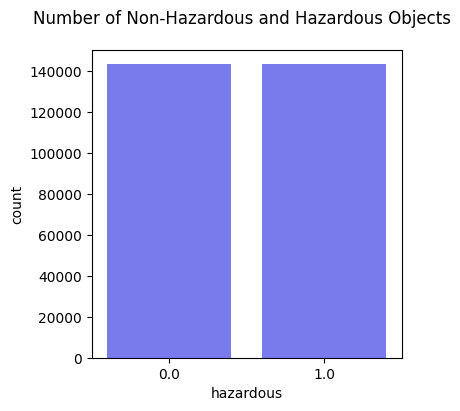

In [ ]:
#After Oversampling Target Variable
df_new=pd.concat([X,y])
sns.axes_style("whitegrid")
sns.countplot(x='hazardous',data=df_new,color='#6667ff',fill=True)
plt.suptitle('Number of Non-Hazardous and Hazardous Objects')
plt.rcParams['figure.figsize']=[4,4]
plt.show()

<h1><strong><font color='#0685c4'>Feature Selection</font> </em></strong> </h1>

In [ ]:
#The tree-based strategies used by random forests naturally rank by how well they improve the purity of the node, or in other words, a decrease in the impurity (Gini impurity) over all trees.
#Nodes with the greatest decrease in impurity happen at the start of the trees, while notes with the least decrease in impurity occur at the end of the trees.
#Thus, by pruning trees below a particular node, we can create a subset of the most important features.

feat_model = RandomForestClassifier(n_estimators=340,random_state = 42) #number of trees in the forest
feat_model.fit(X,y)
importance = feat_model.feature_importances_  #importance of each feature in the decision-making process.
feat_df = pd.DataFrame({"Features":pd.DataFrame(X).columns,"Importance":importance})
feat_df


Features  Importance
0    est_diameter_min    0.275091
1    est_diameter_max    0.240090
2   relative_velocity    0.125066
3       miss_distance    0.110387
4  absolute_magnitude    0.249366

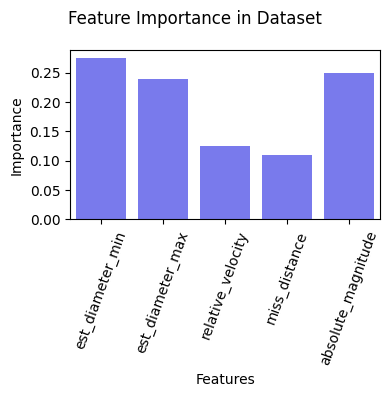

In [ ]:
sns.axes_style("whitegrid")
sns.barplot(data=feat_df,x='Features',y='Importance',color='#6667ff',fill=True)
plt.suptitle('Feature Importance in Dataset')
plt.rcParams['figure.figsize']=[4,4]
plt.xticks(rotation=70)
plt.tight_layout()

## Observations

* Since all the features are important and above 0.10 , we will consider them for machine learning.


<h1><strong><font color='#0685c4'>Data Prep for ML</font> </em></strong> </h1>

In [ ]:
class PrepML:

  def __init__(self,X,y):
    self.X= X
    self.y = y

  def DataSplit(self):
    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size = 0.2, random_state = 42)
    return X_train, X_test, y_train, y_test

  def StandardiseData(self,X_train,X_test):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit the scaler to the features and transform them
    X_train_standardized = scaler.fit_transform(X_train)
    X_test_standardized = scaler.fit_transform(X_test)

    # Convert the standardized features back to a DataFrame for easier handling and visualization (optional)
    X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns)
    X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_test.columns)

    # Display the first few rows of the standardized features
    return X_train_standardized,X_test_standardized

prepml = PrepML(X,y)

In [ ]:
# Spliting the data between train and test dataset
X_train, X_test, y_train, y_test= prepml.DataSplit()

#Printing the shapes of the train and test datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(114612, 5) (28654, 5) (114612, 1) (28654, 1)


In [ ]:
#Standardize the data
X_train_scaled,X_test_scaled = prepml.StandardiseData(X_train,X_test)
X_train_scaled,X_test_scaled

(        est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
 0               0.668812          0.668812           0.037429      -0.810378   
 1               0.126570          0.126570           2.420729       1.727461   
 2               0.067217          0.067217          -1.429781      -0.898710   
 3               1.221455          1.221455           0.277613       1.673821   
 4              -0.664988         -0.664988           0.030038       0.718816   
 ...                  ...               ...                ...            ...   
 114607          0.476720          0.476720          -0.383170       1.485660   
 114608          1.110384          1.110384          -1.108737      -0.021335   
 114609          0.260195          0.260195           0.692747      -1.086196   
 114610          0.814201          0.814201           1.764857      -1.337386   
 114611          0.638858          0.638858          -1.103746      -0.596292   
 
         absolute_magnitud

<h1><strong><font color='#0685c4'>Kfold Validation</font> </em></strong> </h1>

In [ ]:
# Number of splits for K-Fold cross-validation
n_splits = 5
# Initialize the KFold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# Prepare the cross-validation datasets
fold = 0
for train_index, test_index in kf.split(X_train_scaled):
    fold += 1
    X_train_cv, X_test_cv = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Summary for each fold
    print(f"Fold {fold}:")
    print(f"Training set: {len(train_index)} samples")
    print(f"Validation set: {len(test_index)} samples\n")

# Summary of K-Fold cross-validation setu
print(f"K-Fold Cross-Validation setup with {n_splits} folds.")


Fold 1:
Training set: 91689 samples
Validation set: 22923 samples

Fold 2:
Training set: 91689 samples
Validation set: 22923 samples

Fold 3:
Training set: 91690 samples
Validation set: 22922 samples

Fold 4:
Training set: 91690 samples
Validation set: 22922 samples

Fold 5:
Training set: 91690 samples
Validation set: 22922 samples

K-Fold Cross-Validation setup with 5 folds.


<h1><strong><font color='#0685c4'>Machine Learning Model Selection</font> </em></strong> </h1>

In [ ]:
# Define the models
clf = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True), # Enable probability estimates.
    "KNN": KNeighborsClassifier(),
    "GaussianNB":GaussianNB(),
    "Xbg":XGBClassifier()
}

<h1><strong><font color='#0685c4'>Perform CV</font> </em></strong> </h1>

In [ ]:
model_scores = {}

for name, model in clf.items():
    # Cross-validated score
    scores = cross_val_score(model, X_train_cv, y_train_cv, cv=5, scoring='accuracy',n_jobs=-1)
    model_scores[name] = scores.mean()
    print(f"The model {name} Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

The model Logistic Regression Accuracy: 0.9166 (+/- 0.0037)
The model Decision Tree Accuracy: 0.9731 (+/- 0.0024)
The model Random Forest Accuracy: 0.9694 (+/- 0.0020)
The model Gradient Boosting Accuracy: 0.9243 (+/- 0.0025)
The model SVM Accuracy: 0.9183 (+/- 0.0029)
The model KNN Accuracy: 0.9417 (+/- 0.0028)
The model GaussianNB Accuracy: 0.9179 (+/- 0.0029)
The model Xbg Accuracy: 0.9387 (+/- 0.0024)


<h1><strong><font color='#0685c4'>Grid Search with Decision Tree Classifier</font> </em></strong> </h1>

In [ ]:
# Parameter grid for Decision Tree  https://quantdare.com/decision-trees-gini-vs-entropy/
# Gini :The gini impurity measures the frequency at which any element of the dataset will be mislabelled when it is randomly labeled.
# Entropy :Entropy is a measure of information that indicates the disorder of the features with the target. Similar to the Gini Index, the optimum split is chosen by the feature with less entropy.
#It gets its maximum value when the probability of the two classes is the same and a node is pure when the entropy has its minimum value

param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
}

# Grid search
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid,cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_cv, y_train_cv)

# Best parameters and score
#print(grid_search.best_estimator_.get_params().keys())
print('Best Criterion:', grid_search.best_estimator_.get_params()['criterion'])
print('Best max_depth:', grid_search.best_estimator_.get_params()['max_depth'])

Best Criterion: gini
Best max_depth: 150


<h1><strong><font color='#0685c4'>Plot Class</font> </em></strong> </h1>

In [ ]:
class PlotGraph:

  def ROCPlot(self,y_test, y_scores, method):
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend()
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of ' + method)
    plt.rcParams['figure.figsize']=[6,5]
    plt.show()
    return roc_auc


  def PlotModel(self):
    ax =sns.barplot(x=model_scores.keys(),y=model_scores.values(),color='#6667ff',fill=True)
    ax.set(ylabel='Accuracy')
    plt.title('Model Comparisons')
    plt.xticks(rotation=65)
    plt.show(ax)


  def PlotTree(self,clf):
    fig = plt.figure(figsize=(25,20))
    tree.plot_tree(clf, feature_names=clean_data.columns[:-1], class_names=['non hazardous', 'hazardous'], filled=True,fontsize=10,max_depth=3)


  def PlotAccuracies(self,history_NEO):
    """ Plot the history of accuracies"""
    accuracies = [x['Validation_acc'] for x in history_NEO]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title('NEO Accuracy vs. No. of epochs')


  def PlotLosses(self,history_NEO):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('Train_loss') for x in history_NEO]
    val_losses = [x['Validation_loss'] for x in history_NEO]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('NEO Loss vs. No. of Epochs')




pltg = PlotGraph()


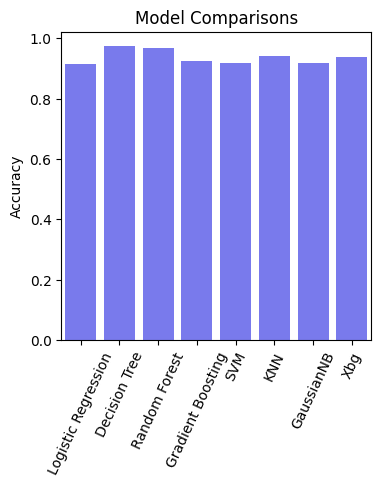

In [ ]:
pltg.PlotModel()

## Observations

* The decision tree classifier and random forest classifer performing best with current dataset.

* We will be using these two for further analysis.

<h1><strong><font color='#0685c4'>Train Model on Complete Dataset</font> </em></strong> </h1>

In [ ]:
# Best hyperparameters found from grid search (example)
from yellowbrick.classifier import ClassificationReport
best_params_rf = {'criterion': 'gini', 'max_depth':12}
clf = DecisionTreeClassifier(**best_params_rf)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"The DecisionTreeClassifier Test Set Accuracy: {accuracy:.4f}")
print(f"The DecisionTreeClassifier Classification Report:\n{classification_report(y_test, y_pred)}\n")

The DecisionTreeClassifier Test Set Accuracy: 0.9212
The DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     14468
           1       0.87      0.98      0.93     14186

    accuracy                           0.92     28654
   macro avg       0.93      0.92      0.92     28654
weighted avg       0.93      0.92      0.92     28654




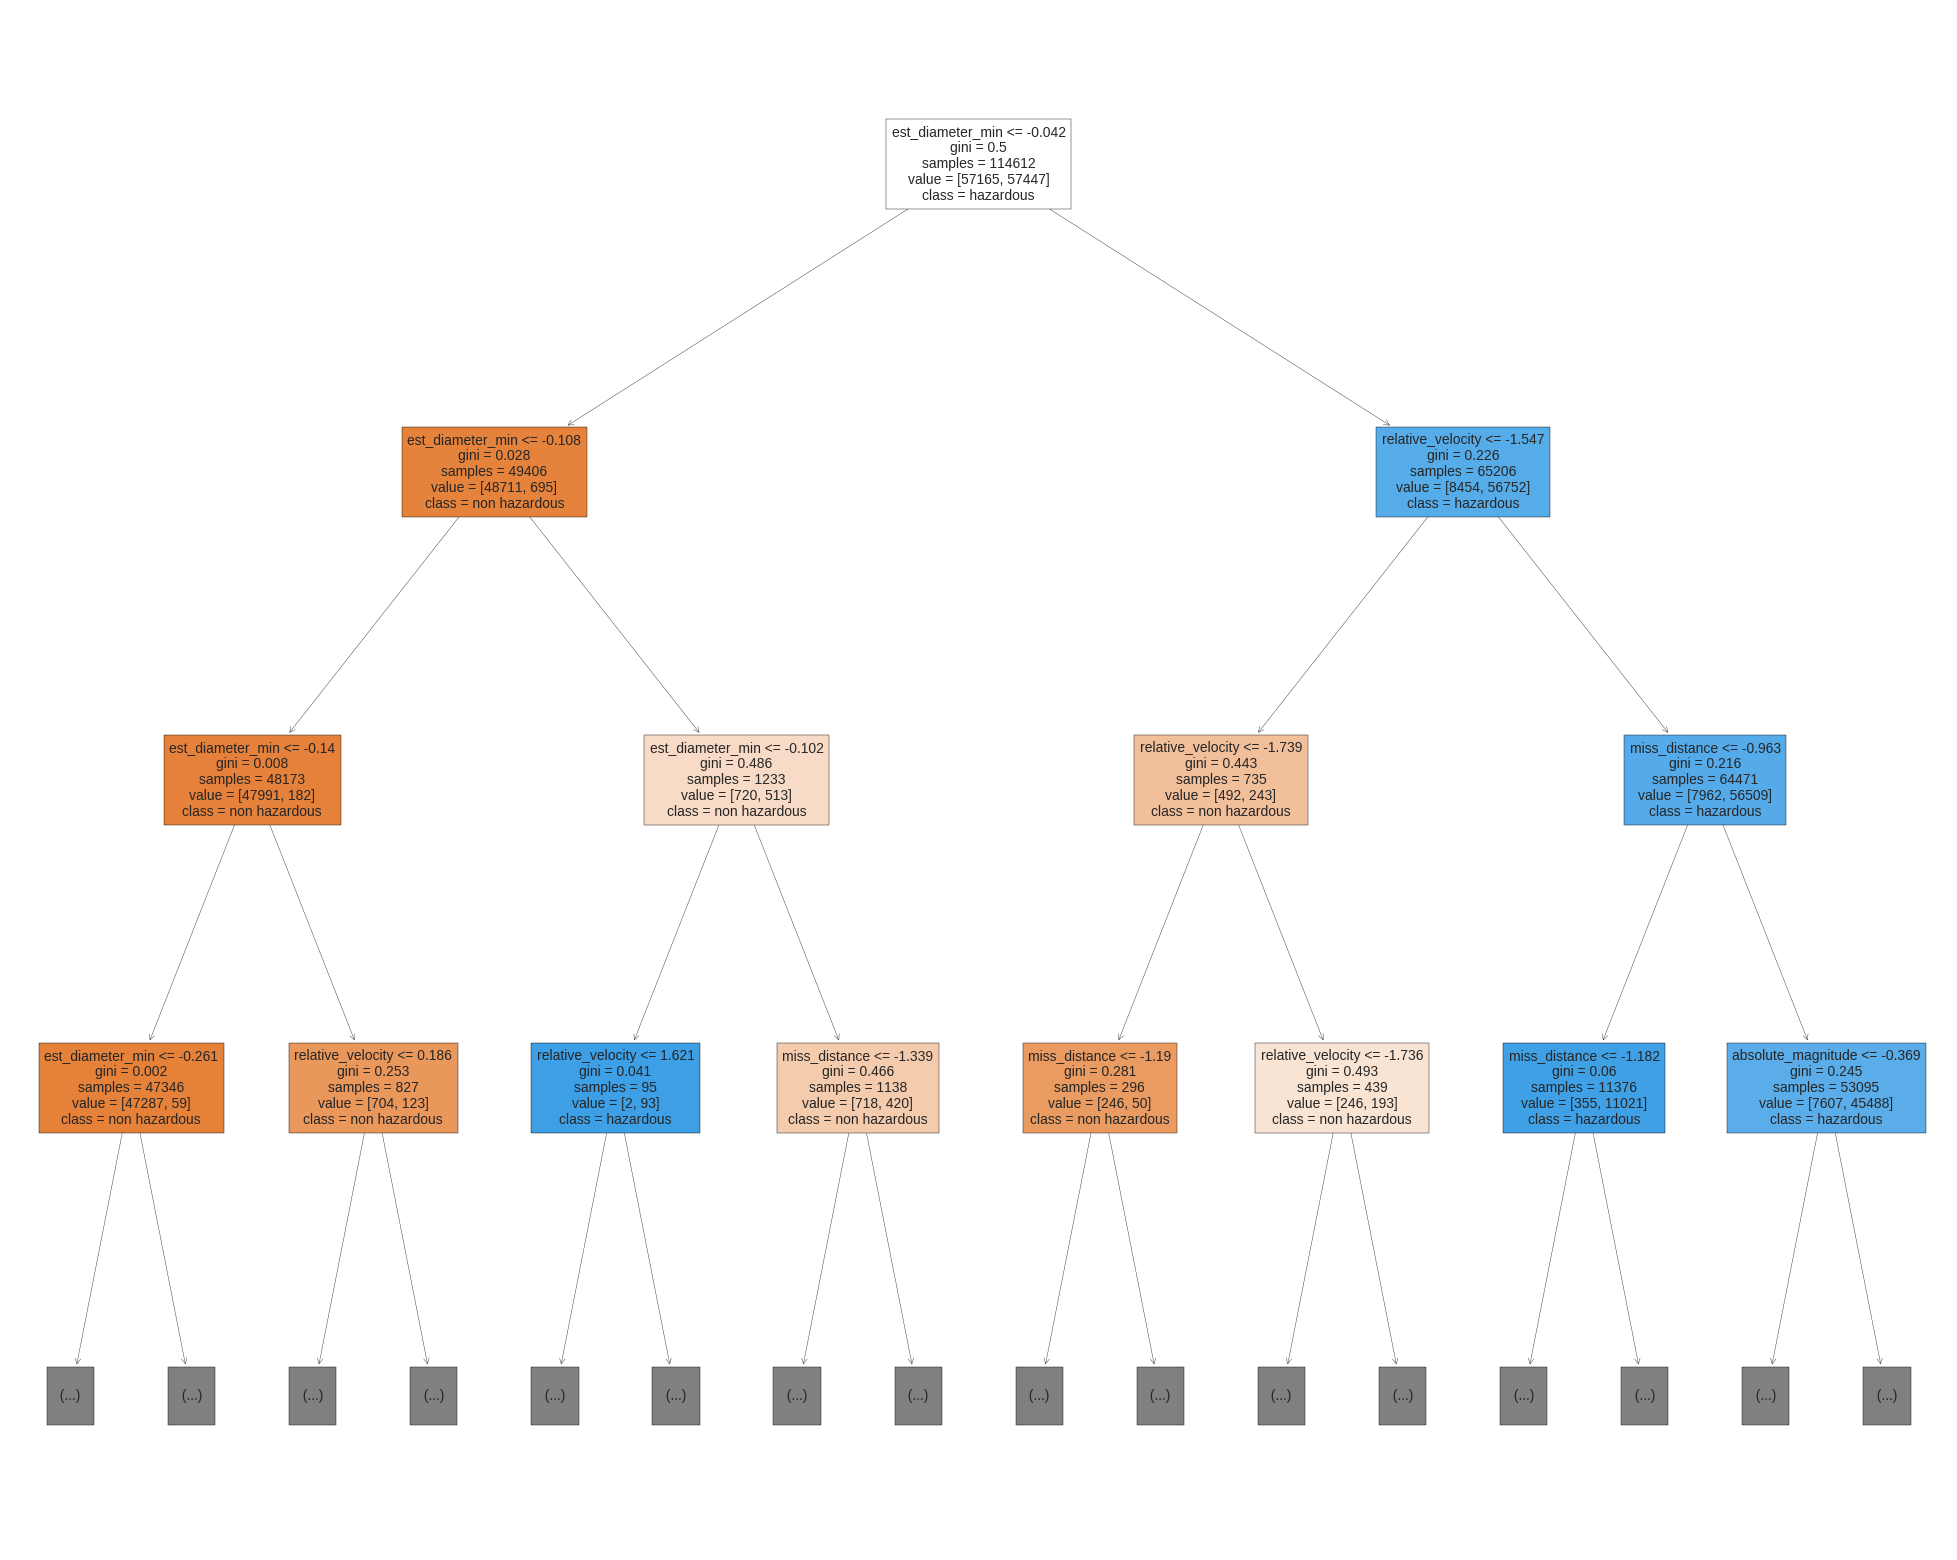

In [ ]:
#Plot graphical tree
pltg.PlotTree(clf)

In [ ]:
%%capture
!pip install yellowbrick

Decision Tree (Gini) - Confusion Matrix


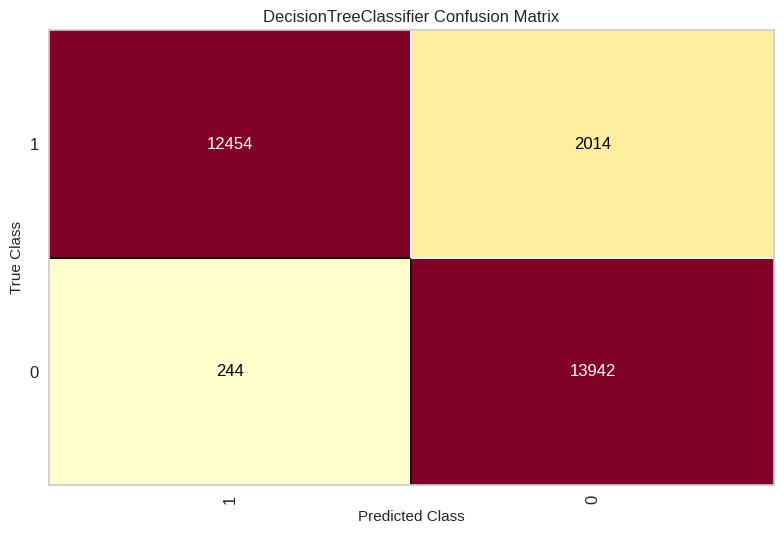

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# Print Confusion Matrix
from yellowbrick.classifier import ConfusionMatrix
print("Decision Tree (Gini) - Confusion Matrix")
cm_clf = ConfusionMatrix(clf,classes=[1,0])
cm_clf.fit(X_train_scaled, y_train)
cm_clf.score(X_test_scaled, y_test)
cm_clf.show()

#1,1=TP
#0,0=TN
#1,0=FN
#0,1=FP


### Observations

* TP values = 12454
* TN values = 13952
* FN values = 2014
* FP values = 244

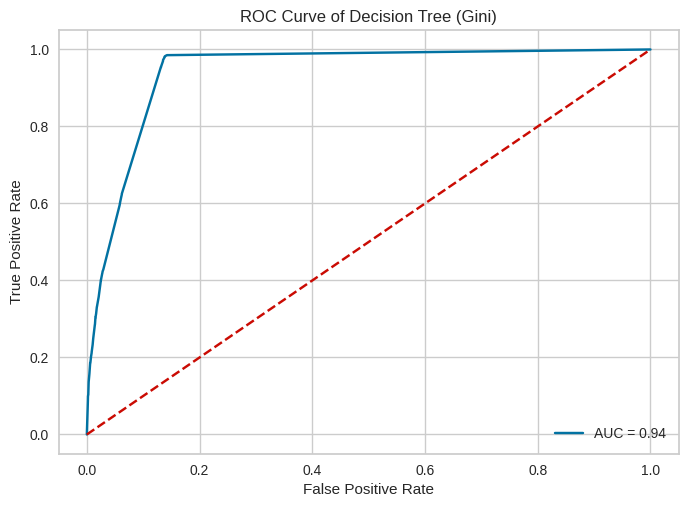

In [ ]:
#Plot ROC curve
y_scores_clf = clf.predict_proba(X_test_scaled)
auc_clf = round(pltg.ROCPlot(y_test, y_scores_clf, 'Decision Tree (Gini)')*100,2)

## Observations

* TP vs FP rate with each other.
* The model has a high true positive rate (sensitivity) and a low false positive rate (1-specificity).
* It demonstrates strong performance in distinguishing between positive and negative instances.
* The ROC curve for the model is positioned well above the diagonal line connecting the points (0,0) and (1,1), which represents random chance.


 An AUC of 0.94 suggests that the model is doing an excellent job in terms of classification, with high overall accuracy and effective separation of the two classes.

<h1><strong><font color='#0685c4'>Grid Search with Random Forest Classifier</font> </em></strong> </h1>

In [ ]:
# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}

# Grid search
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_cv, y_train_cv)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 10}
Best Score: 0.9795070345730178


<h1><strong><font color='#0685c4'>Train Model on Complete Dataset with Random Forest</font> </em></strong> </h1>

In [ ]:
# Best hyperparameters found from grid search (example)
best_params_rf = {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 10}
clf_rf = RandomForestClassifier(**best_params_rf)
clf_rf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"The RandomForestClassifier Test Set Accuracy: {accuracy:.4f}")
print(f"The RandomForestClassifier Classification Report:\n{classification_report(y_test, y_pred)}\n")

The RandomForestClassifier Test Set Accuracy: 0.9212
The RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     14468
           1       0.87      0.98      0.93     14186

    accuracy                           0.92     28654
   macro avg       0.93      0.92      0.92     28654
weighted avg       0.93      0.92      0.92     28654




Decision Tree (Gini) - Confusion Matrix


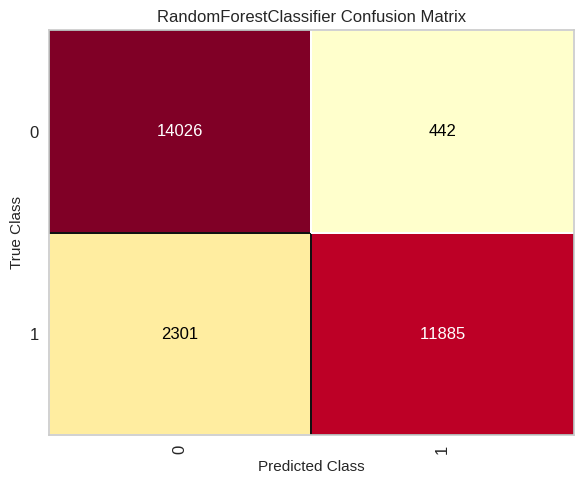

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# Print Confusion Matrix
print("Decision Tree (Gini) - Confusion Matrix")
cm_clf_rf = ConfusionMatrix(clf_rf,classes=[0,1])
cm_clf_rf.fit(X_train_scaled, y_train)
cm_clf_rf.score(X_test_scaled, y_test)
cm_clf_rf.show()

### Observations

* TP values = 11885
* TN values = 14026
* FN values = 2301
* FP values = 442

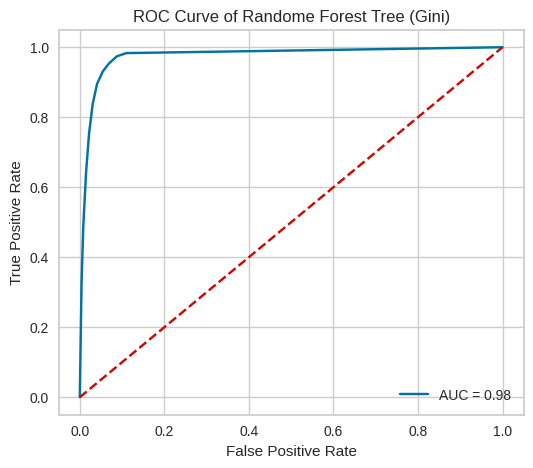

In [ ]:
#Plot ROC curve
y_scores_clf = clf_rf.predict_proba(X_test_scaled)
auc_clf = round(pltg.ROCPlot(y_test, y_scores_clf, 'Randome Forest Tree (Gini)')*100,2)

## Observations

* TP vs FP rate with each other.
* The model has a high true positive rate (sensitivity) and a low false positive rate (1-specificity).
* It demonstrates strong performance in distinguishing between positive and negative instances.
* The ROC curve for the model is positioned well above the diagonal line connecting the points (0,0) and (1,1), which represents random chance.


 An AUC of 0.98 suggests that the model is doing an excellent job in terms of classification, with high overall accuracy and effective separation of the two classes.

<h1><strong><font color='#0685c4'>Pytorch Neural Network</font> </em></strong> </h1>

In [ ]:
# Class Tensor Operations
torch.manual_seed(42)
class Tensoroperations():

    def __init__(self):
        super(Tensoroperations,self).__init__()

    def convert_to_tensor(self,X,y=None):
        X_tensor =  torch.from_numpy(X).float()
        y_tensor = torch.from_numpy(y).float()
        return X_tensor,y_tensor

    def convert_to_test_tensor(self,X):
        X_tensor =  torch.from_numpy(X).float()
        return X_tensor

    def get_dataloaders(self,train_dataset,val_dataset):
        train_loaders = DataLoader(train_dataset,batch_size=32,shuffle=True)
        val_loaders = DataLoader(val_dataset,batch_size=32)
        return train_loaders,val_loaders

    def get_test_dataloaders(self,test_dataset,X_test):
        test_loaders = DataLoader(test_dataset,batch_size=X_test.shape[0])
        return test_loaders



tenops = Tensoroperations()

In [ ]:
# Custom Dataset
class CustomDataset(Dataset):

    def __init__(self,X_data,y_data=None,is_train=True):
        super().__init__()
        if is_train:
            self.X_data = X_data
            self.y_data = y_data
        else:
            self.X_data=X_train

    def __getitem__(self,index):
        return (self.X_data[index],self.y_data[index])

    def __len__(self):
        return len(self.X_data)

In [ ]:
X_tensor_train,y_tensor_train = tenops.convert_to_tensor(X_train_scaled.to_numpy(),y_train.values)
X_tensor_test,y_tensor_test = tenops.convert_to_tensor(X_test_scaled.to_numpy(),y_test.values)
print('The training tensor \n',X_tensor_train,y_tensor_train)
print('The validation tensor \n',X_tensor_test,y_tensor_test)

The training tensor 
 tensor([[ 0.6688,  0.6688,  0.0374, -0.8104, -0.7107],
        [ 0.1266,  0.1266,  2.4207,  1.7275, -0.4442],
        [ 0.0672,  0.0672, -1.4298, -0.8987, -0.4098],
        ...,
        [ 0.2602,  0.2602,  0.6927, -1.0862, -0.5173],
        [ 0.8142,  0.8142,  1.7649, -1.3374, -0.7709],
        [ 0.6389,  0.6389, -1.1037, -0.5963, -0.6978]]) tensor([[1.],
        [0.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])
The validation tensor 
 tensor([[ 1.1227,  1.1227, -0.7471,  0.9623, -0.8893],
        [ 0.6504,  0.6504, -0.1158, -1.0788, -0.7051],
        [-0.2479, -0.2479, -0.5302,  0.8649, -0.2037],
        ...,
        [ 1.1106,  1.1106, -1.0692, -0.2790, -0.8851],
        [-1.0513, -1.0513, -0.8734, -1.1431,  0.7433],
        [-1.3250, -1.3250, -0.7032,  1.5315,  1.6004]]) tensor([[1.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]])


In [ ]:
print('The training shapes \n',X_tensor_train.shape,y_tensor_train.shape)
print('The test shapes \n',X_tensor_test.shape,y_tensor_test.shape)

The training shapes 
 torch.Size([114612, 5]) torch.Size([114612, 1])
The test shapes 
 torch.Size([28654, 5]) torch.Size([28654, 1])


<h1><strong><font color='#0685c4'>NEO Base Class</font> </em></strong> </h1>

In [ ]:
%%capture
!pip install torchmetrics
false_pos,true_pos = [],[]

In [ ]:
from torchmetrics.classification import BinaryAccuracy,BinaryROC
from torchmetrics import ROC
class NEOClassificationBase(torch.nn.Module):

    def _accuracy(self,outputs, labels):
        #return torch.tensor(outputs.round() == labels).float().mean()
        metric = BinaryAccuracy()
        return metric(outputs, labels.view(-1, 1))


    def training_step(self,batch):
        features,labels = batch
        out = self(features)
        loss = F.binary_cross_entropy(out, labels.view(-1, 1))
        return loss

    def validation_step(self, batch):
        features, labels = batch
        out = self(features)                    # Generate predictions
        loss = F.binary_cross_entropy(out,  labels.view(-1, 1))   # Calculate loss
        acc = self._accuracy(out,  labels.view(-1, 1))           # Calculate accuracy
        self._get_roc(out, labels)
        return {'Validation_loss': loss.detach(), 'Validation_acc': acc}

    def _get_roc(self,output,labels):
        roc = ROC(task="binary")
        fpr, tpr, thresholds = roc(output, (labels.long()).view(-1, 1))
        false_pos.append(fpr)
        true_pos.append(tpr)


    def validation_epoch_end(self, outputs):
        batch_losses = [x['Validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Validation_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Validation_loss': epoch_loss.item(), 'Validation_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        if epoch%10 == 0:
            print("Epoch [{}], Train_loss: {:.4f}, Validation_loss: {:.4f}, Validation_acc: {:.4f}".format(
                epoch, result['Train_loss'], result['Validation_loss'], result['Validation_acc']))

<h1><strong><font color='#0685c4'>DNN Model</font> </em></strong> </h1>

In [ ]:
n_output =  1   # Number of output nodes = for binary classifier

class BinaryClassificationNN(NEOClassificationBase):

     def __init__(self,n_input_dim):
        super(BinaryClassificationNN, self).__init__()

        self.network = torch.nn.Sequential(
            torch.nn.Linear(n_input_dim,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,n_output),
            torch.nn.Sigmoid()
        )
     def forward(self, xb):
        return self.network(xb)


model_NEO = BinaryClassificationNN(X_train_scaled.shape[1])


In [ ]:
print(model_NEO)

BinaryClassificationNN(
  (network): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


<h1><strong><font color='#0685c4'>Train and Test DataLaoders</font> </em></strong> </h1>

In [ ]:
train_dataset = CustomDataset(X_tensor_train,y_tensor_train.squeeze(1))
test_dataset = CustomDataset(X_tensor_test,y_tensor_test.squeeze(1))
train_dataloader = DataLoader(train_dataset,64,shuffle=True)
test_dataloader = DataLoader(test_dataset,64)

<h1><strong><font color='#0685c4'>GPU or CPU</font> </em></strong> </h1>

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


<h1><strong><font color='#0685c4'>Tariner Class</font> </em></strong> </h1>

In [ ]:
class Trainer:

    @torch.no_grad()
    def _evaluate(self,model, val_loader):
        model.eval()
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)


    def fit(self,epochs,lr,model, train_loader, val_loader, opt_func):

        history = []
        optimizer = opt_func(model.parameters(),lr,weight_decay=2e-5)
        for epoch in tqdm(range(epochs)):

            model.train()
            train_losses = []
            for batch in train_loader:
                loss = model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            result = self._evaluate(model, val_loader)
            result['Train_loss'] = torch.stack(train_losses).mean().item()
            model.epoch_end(epoch, result)
            history.append(result)

        return history

In [ ]:
num_epochs=50
lr=1e-3
opt_func= torch.optim.SGD

In [ ]:
tariner=Trainer()
history_NEO = tariner.fit(num_epochs,lr, model_NEO, train_dataloader, test_dataloader, opt_func)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0], Train_loss: 0.6807, Validation_loss: 0.6597, Validation_acc: 0.7994
Epoch [10], Train_loss: 0.2438, Validation_loss: 0.2484, Validation_acc: 0.9142
Epoch [20], Train_loss: 0.2311, Validation_loss: 0.2362, Validation_acc: 0.9155
Epoch [30], Train_loss: 0.2260, Validation_loss: 0.2310, Validation_acc: 0.9161
Epoch [40], Train_loss: 0.2237, Validation_loss: 0.2288, Validation_acc: 0.9164


### Observations

* The overall accuracy is clsoe to 91% for tabular data.

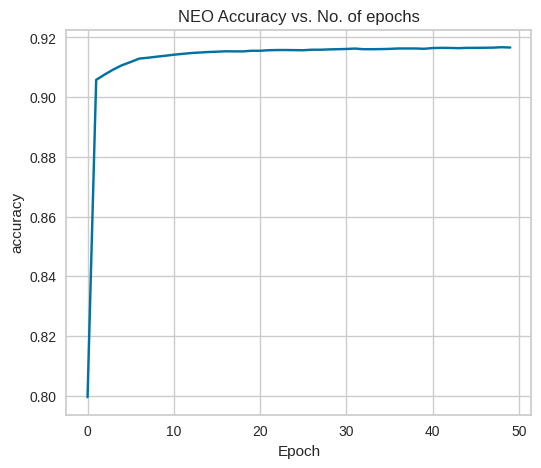

In [ ]:
# Plotting Accuracy
pltg.PlotAccuracies(history_NEO)

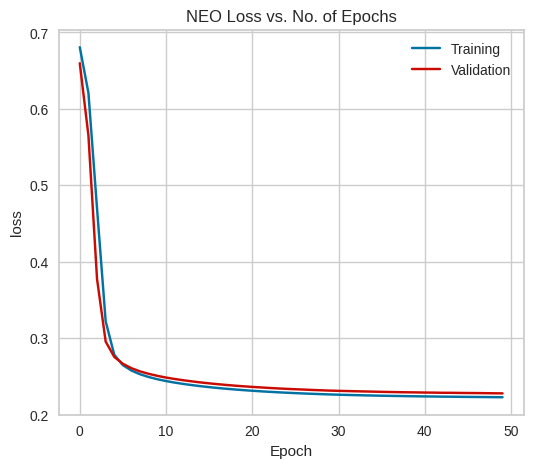

In [ ]:
# Plot Loss Vs Epochs
pltg.PlotLosses(history_NEO)

<h1><strong><font color='#0685c4'>Custom Test Data</font> </em></strong> </h1>

In [ ]:
class CustomDataTest(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data


    def __getitem__(self, index):
            return self.X_data[index]

    def __len__ (self):
        return len(self.X_data)

In [ ]:
# Test Data Loader
test_dataset = CustomDataTest(X_tensor_test)
test_dataloader = DataLoader(test_dataset,64)

<h1><strong><font color='#0685c4'>Evaluate Model</font> </em></strong> </h1>

In [ ]:
class Evaluate:

    def eval_test_data(self,model,test_data_dl):
        neo_target = []
        model.eval()
        with torch.no_grad():
            for X_batch_test in test_data_dl:
                X_batch_test = X_batch_test.to(device)
                y_test_pred = model(X_batch_test)
                y_pred_tag = torch.sigmoid(y_test_pred)
                neo_target.append(y_pred_tag.cpu())
        return [a.squeeze().tolist() for a in neo_target]


eva = Evaluate()



In [ ]:
from collections.abc import Iterable
def flatten(lis):
    for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:
            yield item

neo = eva.eval_test_data(model_NEO,test_dataloader)
neo

[[0.6879942417144775,
  0.7182511687278748,
  0.5106021761894226,
  0.5,
  0.5,
  0.5000216960906982,
  0.7204436659812927,
  0.5,
  0.5,
  0.6924677491188049,
  0.7180826663970947,
  0.6768648624420166,
  0.6904407143592834,
  0.7141562700271606,
  0.6892079710960388,
  0.5055311322212219,
  0.7140676379203796,
  0.5351021885871887,
  0.5000001788139343,
  0.7201409935951233,
  0.5000144839286804,
  0.720228910446167,
  0.7224681377410889,
  0.7088061571121216,
  0.5,
  0.697091281414032,
  0.7038310766220093,
  0.5,
  0.7061118483543396,
  0.5021241903305054,
  0.5000004172325134,
  0.5,
  0.5,
  0.5000200271606445,
  0.7003886103630066,
  0.6254082918167114,
  0.6961408853530884,
  0.7063186764717102,
  0.5,
  0.6999048590660095,
  0.7025866508483887,
  0.5000000596046448,
  0.5000004172325134,
  0.7085770964622498,
  0.5,
  0.6963058114051819,
  0.7193964123725891,
  0.7014498710632324,
  0.6970027685165405,
  0.6935773491859436,
  0.5000002980232239,
  0.710538387298584,
  0.5,
  

<h1><strong><font color='#0685c4'>Generating Synthetic Data Using GANS in Tensorflow </font> </em></strong> </h1>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

<h1><strong><font color='#0685c4'>Data PreProcessing</font> </em></strong> </h1>

In [ ]:
# Normalize the data
X_real = clean_data.drop(['hazardous'],axis=1)
y_real = clean_data.drop(['est_diameter_min','est_diameter_max','relative_velocity','miss_distance','absolute_magnitude'],axis=1)


# Normalize the data
scaler = StandardScaler()
X_real = scaler.fit_transform(X)

# Convert data to pandas DataFrame
real_data = pd.DataFrame(X_real, columns=['est_diameter_min','est_diameter_max','relative_velocity','miss_distance','absolute_magnitude'])
real_data = real_data.drop_duplicates()
real_labels = y_real

# One hot encode labels
label_encoder = LabelEncoder()
label_encoder_labels = label_encoder.fit_transform(np.array(real_labels).reshape(-1, 1))

In [ ]:
real_data

est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
0             -0.136050         -0.136050          -1.118893      -0.512144   
1             -0.994090         -0.994090          -0.685519       0.179815   
2              0.935341          0.935341          -0.993191      -0.346166   
3             -1.436666         -1.436666           0.371261       0.843395   
4             -0.003237         -0.003237          -0.043263       0.077948   
...                 ...               ...                ...            ...   
76662         -1.133514         -1.133514           0.122801      -1.112023   
76663         -1.273438         -1.273438          -0.148329       0.807140   
76664         -1.056826         -1.056826          -1.900675      -0.376691   
76665         -1.408239         -1.408239           0.901072       1.463481   
76666         -0.944058         -0.944058          -1.016149       1.056093   

       absolute_magnitude  
0               -0.281719  
1                0.628948  
2               -0.818669  
3                2.420213  
4               -0.367631  
...                   ...  
76662            0.921049  
76663            1.350609  
76664            0.749225  
76665            2.123816  
76666            0.543036  

[76660 rows x 5 columns]

<h1><strong><font color='#0685c4'>Hyper Parameters</font> </em></strong> </h1>

In [ ]:
# Constants
NOISE_DIM = 100
NUM_CLASSES = 1
NUM_FEATURES = 5
BATCH_SIZE = 64
TRAINING_STEPS = 1000

<h1><strong><font color='#0685c4'>Generator Discriminator and GAN</font> </em></strong> </h1>

In [ ]:
# Generator
def create_generator():
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([noise_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(NUM_FEATURES, activation='linear')(hidden)
    model = Model(inputs=[noise_input, class_input], outputs=output)
    return model

# Discriminator
def create_discriminator():
    data_input = Input(shape=(NUM_FEATURES,))
    class_input = Input(shape=(NUM_CLASSES,))
    merged_input = Concatenate()([data_input, class_input])
    hidden = Dense(128, activation='relu')(merged_input)
    output = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=[data_input, class_input], outputs=output)
    return model

# cGAN
def create_cgan(generator, discriminator):
    noise_input = Input(shape=(NOISE_DIM,))
    class_input = Input(shape=(NUM_CLASSES,))
    generated_data = generator([noise_input, class_input])
    validity = discriminator([generated_data, class_input])
    model = Model(inputs=[noise_input, class_input], outputs=validity)
    return model

<h1><strong><font color='#0685c4'>Compile Models</font> </em></strong> </h1>

In [ ]:
# Create and compile the Discriminator
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

# Create the Generator
generator = create_generator()

# Create the GAN
gan = create_cgan(generator, discriminator)

# Ensure that only the generator is trained
discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer=Adam())

<h1><strong><font color='#0685c4'>GAN Training</font> </em></strong> </h1>

In [ ]:
# Train GAN
for step in range(TRAINING_STEPS):
    # Select a random batch of real data with labels
    idx = np.random.randint(0, real_data.shape[0], BATCH_SIZE)
    real_batch = real_data.iloc[idx].values
    labels_batch = one_hot_labels[idx]

    # Generate a batch of new data
    noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))
    generated_batch = generator.predict([noise, labels_batch])

    # Train the discriminator
    real_loss = discriminator.train_on_batch([real_batch, labels_batch], np.ones((BATCH_SIZE, 1)))
    fake_loss = discriminator.train_on_batch([generated_batch, labels_batch], np.zeros((BATCH_SIZE, 1)))
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train the generator
    generator_loss = gan.train_on_batch([noise, labels_batch], np.ones((BATCH_SIZE, 1)))

    if step % 500 == 0:
        print(f"Step: {step}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}")

# Generate instances for a given class
def generate_data(generator, data_class, num_instances):
    one_hot_class = label_encoder.transform(np.array([[data_class]]))
    noise = np.random.normal(0, 1, (num_instances, NOISE_DIM))
    generated_data = generator.predict([noise, np.repeat(one_hot_class, num_instances, axis=0)])
    return pd.DataFrame(generated_data, columns=['est_diameter_min','est_diameter_max','relative_velocity','miss_distance','absolute_magnitude'])

# Generate 40 instances of class 1
generated_data = generate_data(generator, 1, 40)
generated_data.head()

2/2 [==============================] - 0s 8ms/step
Step: 0, Discriminator Loss: 0.7546258568763733, Generator Loss: 0.7387604713439941
2/2 [==============================] - 0s 5ms/step
Step: 500, Discriminator Loss: 0.6484998166561127, Generator Loss: 0.7351303696632385
2/2 [==============================] - 0s 7ms/step


est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
0         -1.143444         -1.106729          -0.739594      -1.194289   
1         -0.244430         -0.118282          -0.592080      -1.269489   
2         -0.607170         -0.460356          -0.705928      -1.610257   
3         -1.480582         -1.516219          -1.326811      -2.036448   
4         -0.680436         -0.597816          -0.450900      -0.967676   

   absolute_magnitude  
0            1.005264  
1            0.229181  
2            0.579398  
3            1.745379  
4            0.737232

<h1><strong><font color='#0685c4'>Save Synthetic data</font> </em></strong> </h1>

In [ ]:
# Generate 50 instances for each class
synthetic_data_class_0 = generate_data(generator, 0, 100)
synthetic_data_class_1 = generate_data(generator, 1, 100)

# Combine all synthetic data into a single DataFrame and apply inverse transform to bring it back to original scale
synthetic_data = pd.concat([synthetic_data_class_0, synthetic_data_class_1], ignore_index=True)
synthetic_data = pd.DataFrame(scaler.inverse_transform(synthetic_data), columns=['est_diameter_min','est_diameter_max','relative_velocity','miss_distance','absolute_magnitude'])

# Create corresponding class labels
synthetic_labels = [0]*100 + [1]*100

# Add labels to the synthetic data
synthetic_data['class'] = synthetic_labels

# Save synthetic data as a CSV file
synthetic_data.to_csv('synthetic_neo_data.csv', index=False)

4/4 [==============================] - 0s 3ms/step


<h1><strong><font color='#0685c4'>Load Synthetic Data and Plot Results</font> </em></strong> </h1>

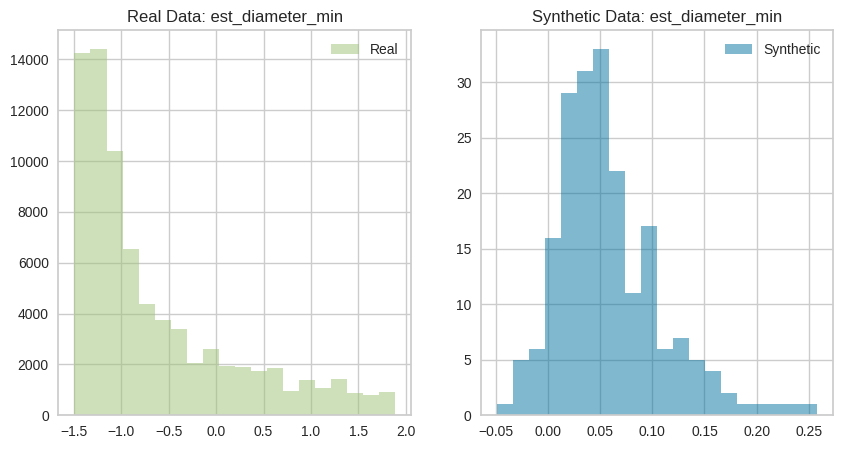

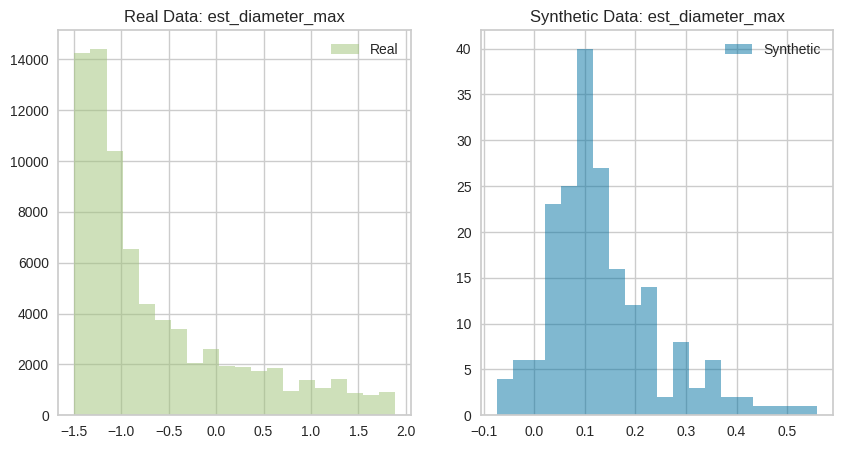

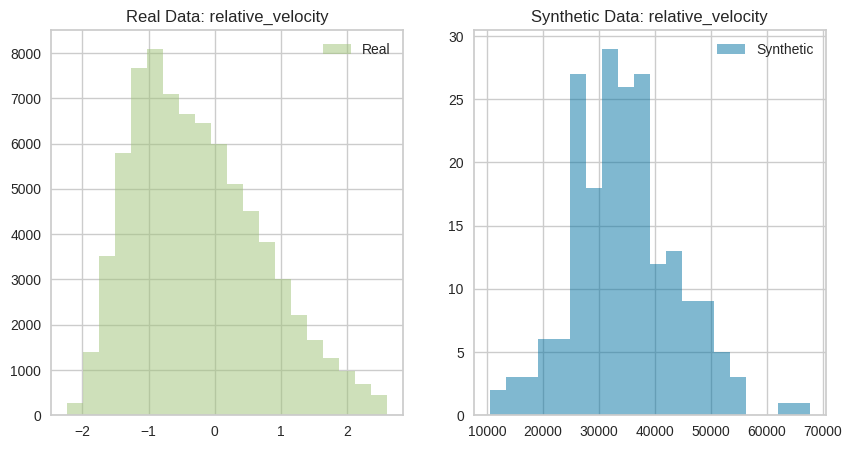

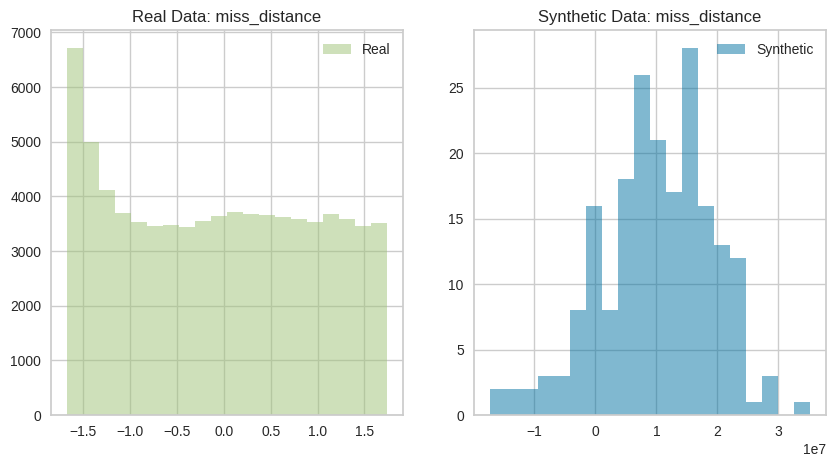

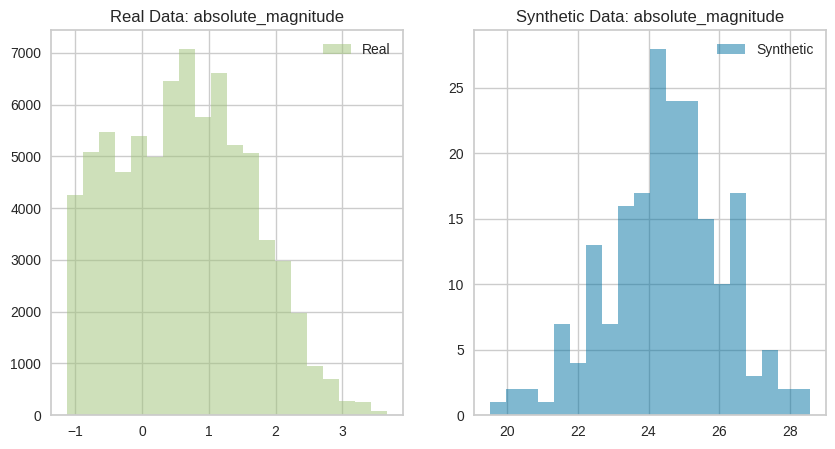

In [ ]:
# Load the synthetic dataset
synthetic_data = pd.read_csv('/content/synthetic_neo_data.csv')

# For each feature, create a histogram for the real and synthetic data
for feature in ['est_diameter_min','est_diameter_max','relative_velocity','miss_distance','absolute_magnitude']:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(real_data[feature], bins=20, alpha=0.5, color='g', label='Real')
    plt.title(f"Real Data: {feature}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(synthetic_data[feature], bins=20, alpha=0.5, color='b', label='Synthetic')
    plt.title(f"Synthetic Data: {feature}")
    plt.legend()

    plt.show()



<h1><strong><font color='#0685c4'>Summaries</font> </em></strong> </h1>

In [ ]:
# Print the summary statistics for the real and synthetic data
print("Summary statistics for the real data:")
print(real_data.describe())
print("\nSummary statistics for the synthetic data:")
print(synthetic_data.describe())



Summary statistics for the real data:
       est_diameter_min  est_diameter_max  relative_velocity  miss_distance  \
count      76660.000000      76660.000000       76660.000000   76660.000000   
mean          -0.655575         -0.655575          -0.247149      -0.067792   
std            0.828861          0.828861           0.967065       1.026586   
min           -1.492768         -1.492768          -2.235411      -1.673495   
25%           -1.273438         -1.273438          -1.009681      -1.004155   
50%           -0.989291         -0.989291          -0.379969      -0.073445   
75%           -0.257178         -0.257178           0.399660       0.820369   
max            1.882122          1.882122           2.605593       1.742284   

       absolute_magnitude  
count        76660.000000  
mean             0.625993  
std              0.991423  
min             -1.123656  
25%             -0.195807  
50%              0.620357  
75%              1.350609  
max              3.670232 

<h1><strong><font color='#0685c4'>Scatter Plot Real Vs Syntheic Data</font> </em></strong> </h1>

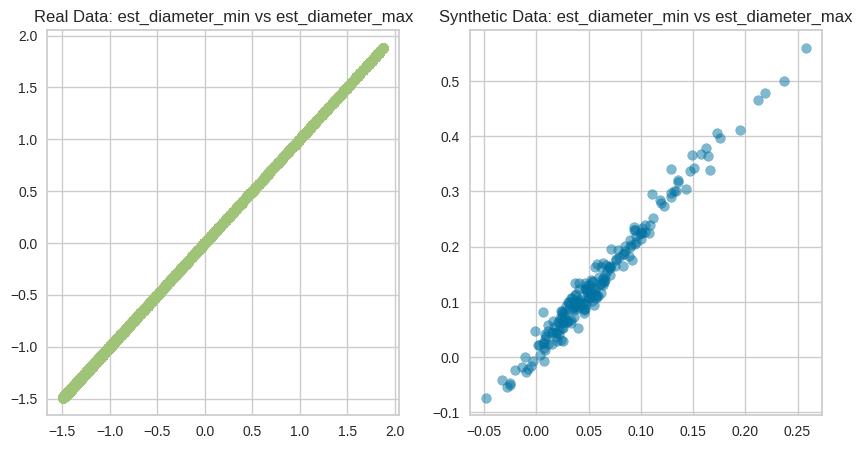

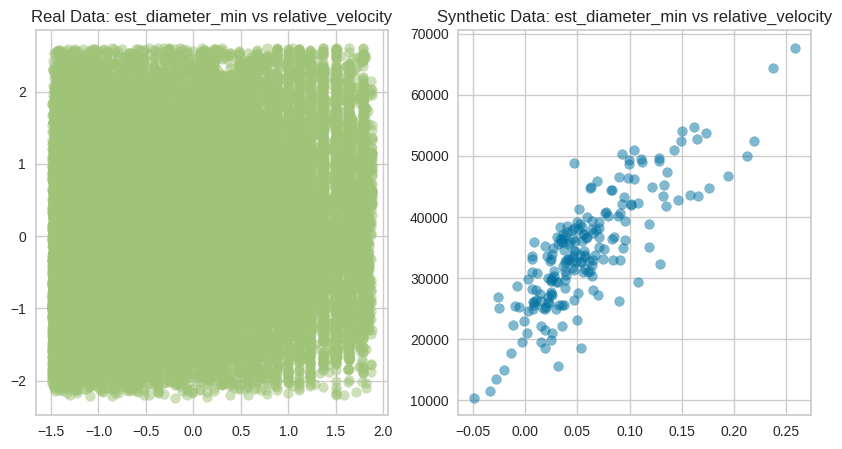

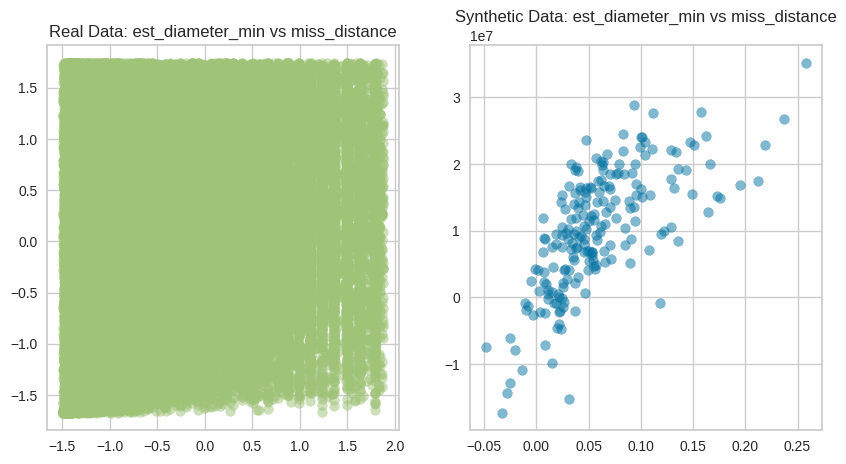

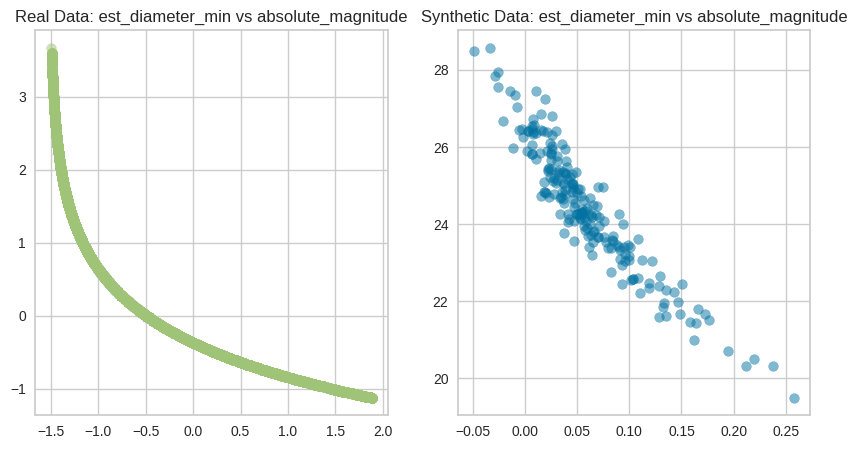

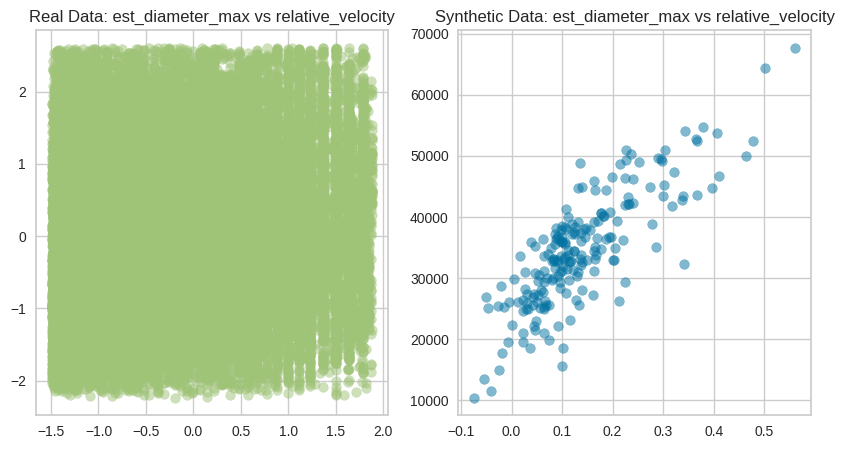

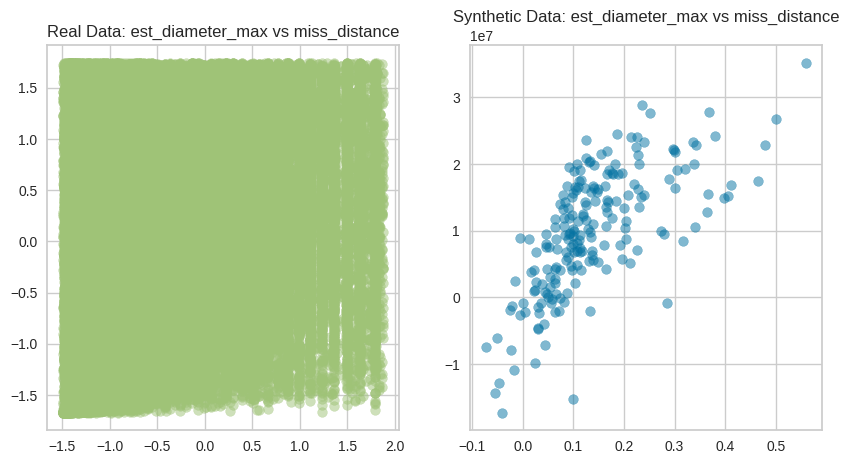

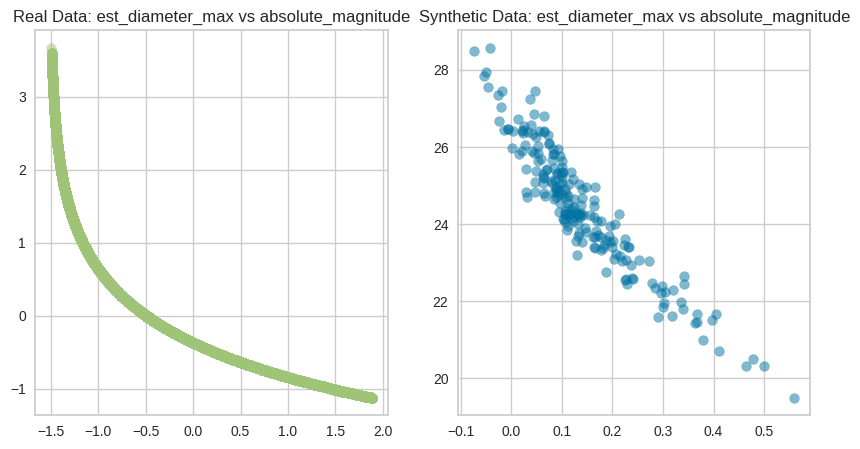

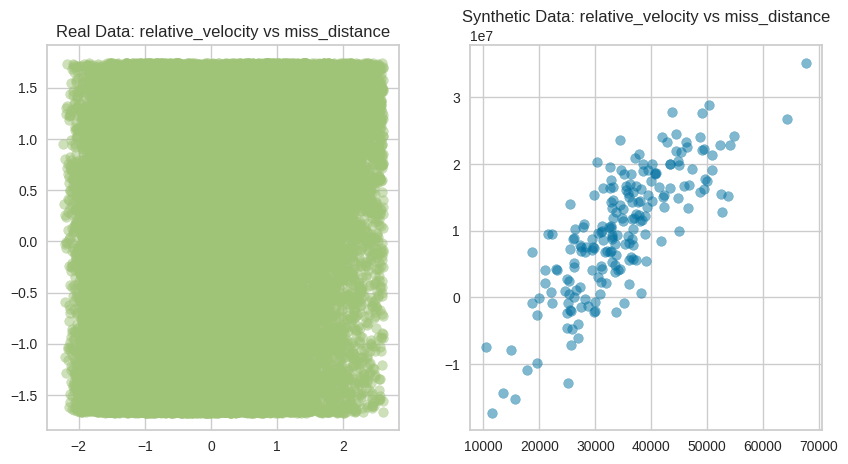

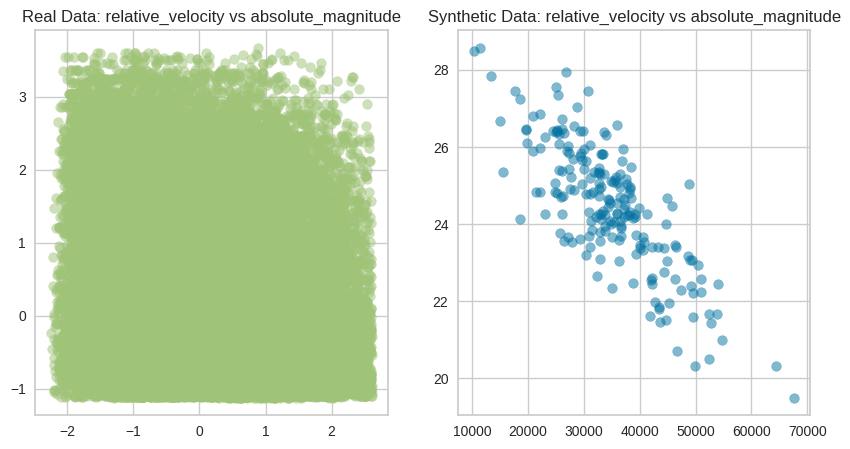

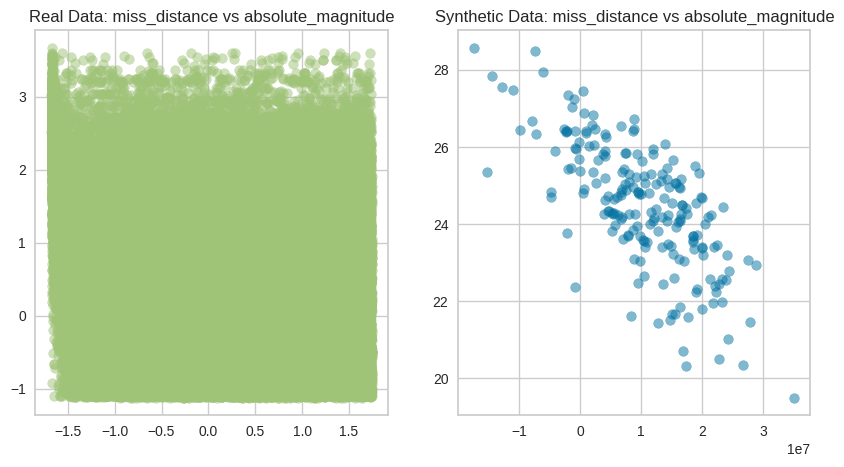

In [ ]:
# For each pair of features, create a scatter plot for the real and synthetic data
features = ['est_diameter_min','est_diameter_max','relative_velocity','miss_distance','absolute_magnitude']
for i in range(len(features)):
    for j in range(i+1, len(features)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(real_data[features[i]], real_data[features[j]], alpha=0.5, color='g')
        plt.title(f"Real Data: {features[i]} vs {features[j]}")

        plt.subplot(1, 2, 2)
        plt.scatter(synthetic_data[features[i]], synthetic_data[features[j]], alpha=0.5, color='b')
        plt.title(f"Synthetic Data: {features[i]} vs {features[j]}")

        plt.show()

<h1><strong><font color='#0685c4'>Future Work for Machine Learning Model</font> </em></strong> </h1>

The machine learning models can further be tuned in the following way:

* Since the original data is im balanced, I have used RandomOver sampler as per the f-measure value and accuracy Random Over Sampler performs best followed by
SMOTE and ADASYN. We can try using SMOTE and check if the model is performing better in such cases.

* I also can check with MinMaxScaler instead of StandardScaler to verify the Machine Learning performance.

* All base version of machine learning models can be parameterized with many set of parameters using any hyper parameter optimization techniques like BayesianOptimization to make model better predictor.


<h1><strong><font color='#0685c4'>Future Work for Deep Learning Model</font> </em></strong> </h1>

The deep neural network can further be optimized with the help of
hyper parameter optimization libraries as follows:

* RayTune => https://docs.ray.io/en/latest/tune/index.html
* Hyperopt => http://hyperopt.github.io/hyperopt/
* Optuna => https://optuna.org/
* µTransfer =>  https://www.microsoft.com/en-us/research/blog/%C2%B5transfer-a-technique-for-hyperparameter-tuning-of-enormous-neural-networks/
* AutoML => https://cloud.google.com/automl



Instead of using vanilla Pytorch model we can also use several other Pytorch
frameworks

* Tabular Pytorch Framework => https://pytorch-tabular.readthedocs.io/en/latest/
* WideDeep Pytorch Framework => https://github.com/jrzaurin/pytorch-widedeep


